# Imports




In [54]:
# ============================================================
# CELL 1: IMPORTS
# ============================================================
# ============================================================
# GLASS PIPELINE MODULES
# ============================================================
from data.preprocessing.bank_preprocessing import BankPreprocessor
from data.global_splits.split_manager import GlobalSplitManager
from lr.feature_engineering import engineer_features
from lr.correlation_analysis import analyze_and_prune_features
from lr.lr_stage import train_lr_stage
from lr.lr_stage_calibrated import train_calibrated_lr_stage
from glass_brw.rf.lift_analysis import analyze_rf_lift
from glass_brw.rf.brw_feature_engineering import prepare_brw_data
from glass_brw.rf.rf_stage import train_rf_stage
from glass_brw.segment_builder import BankSegmentBuilder, prepare_segments
from glass_brw.core.rule import Rule, SUBSCRIBE, NOT_SUBSCRIBE, ABSTAIN
from glass_brw.ilp_rule_selector.ilp_rule_selector import ILPRuleSelector
# ============================================================
# REFACTORED GLASS-BRW MODULES (NEW)
# ============================================================
from glass_brw.rule_generator.rule_generator import RuleGenerator
from glass_brw.rule_evaluator.rule_evaluator import RuleEvaluator
from glass_brw.glass_brw.performance_analyzer import PerformanceAnalyzer  # EXTRACTED ANALYSIS
from glass_brw.glass_brw.model_saver import ModelSaver  # EXTRACTED SAVER
from glass_brw.glass_brw.rule_diagnostics import RuleDiagnostics  # EXTRACTED DIAGNOSTICS
# ============================================================
# PYTHON STANDARD LIBRARY
# ============================================================
from datetime import datetime
import time

# ============================================================
# CORE NUMERICAL & DATA HANDLING
# ============================================================
import numpy as np
import pandas as pd
import joblib

# ============================================================
# SKLEARN: MODEL SELECTION & PREPROCESSING
# ============================================================
from sklearn.model_selection import train_test_split

# ============================================================
# SKLEARN: METRICS
# ============================================================
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)



# Load/Inspect Data

In [2]:
# ============================================================
# CELL 2: LOAD & PREPROCESS
# ============================================================
df = pd.read_csv("./data/raw/bank-additional-full.csv", sep=";")
print(f"Loaded: {df.shape}")

preprocessor = BankPreprocessor(drop_leaky=True)
df_processed = preprocessor.fit_transform(df)


Loaded: (41188, 21)

🔧 PREPROCESSING: Bank Marketing Dataset
✅ Target 'y': {0: 36548, 1: 4640}
✅ Binary cols (unknown=-1): ['default', 'housing', 'loan']
✅ contact: {0: 26144, 1: 15044}
✅ month: [np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(10), np.int8(11), np.int8(12)]
✅ day_of_week: [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4)]
✅ poutcome: {0: 35563, 1: 4252, 2: 1373}
✅ education: ordinal 0-6, unknown=-1
✅ job: 12 categories label-encoded
✅ marital: {1: 24928, 2: 11568, 0: 4612, -1: 80}

📊 Economic features (already numeric):
  emp.var.rate: [-3.400, 1.400]
  cons.price.idx: [92.201, 94.767]
  cons.conf.idx: [-50.800, -26.900]
  euribor3m: [0.634, 5.045]
  nr.employed: [4963.600, 5228.100]

📊 Campaign features (already numeric):
  age: [17, 98]
  duration: [0, 4918]
  campaign: [1, 56]
  pdays: [0, 999]
  previous: [0, 7]
⚠️  Dropped leaky features: ['duration', 'pdays', 'poutcome']

✅ df_proc ready: (41188, 18)
Memory: 2

# Inspect expected column inputs

In [4]:
# ============================================================
# CELL 3: EXAMINE CATAGORICAL COLUMNS
# ============================================================
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("📌 CATEGORICAL COLUMNS\n" + "-"*60)
categorical_cols

for col in categorical_cols:
    print(f"\n🔎 Column: {col}")
    print("-" * 40)

    values = (
        df[col]
        .astype(str)
        .value_counts(dropna=False)
        .sort_index()
    )

    print(values)


📌 CATEGORICAL COLUMNS
------------------------------------------------------------

🔎 Column: job
----------------------------------------
job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
Name: count, dtype: int64

🔎 Column: marital
----------------------------------------
marital
divorced     4612
married     24928
single      11568
unknown        80
Name: count, dtype: int64

🔎 Column: education
----------------------------------------
education
basic.4y                4176
basic.6y                2292
basic.9y                6045
high.school             9515
illiterate                18
professional.course     5243
university.degree      12168
unknown                 1731
Name: count, dtype: int64

🔎 Column: default
----------------------------------------

# Preprocessing

In [5]:
# ============================================================
# CELL 4: PREPROCESSING
# ============================================================
preprocessor = BankPreprocessor(drop_leaky=True)
df_proc = preprocessor.fit_transform(df)


🔧 PREPROCESSING: Bank Marketing Dataset
✅ Target 'y': {0: 36548, 1: 4640}
✅ Binary cols (unknown=-1): ['default', 'housing', 'loan']
✅ contact: {0: 26144, 1: 15044}
✅ month: [np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(10), np.int8(11), np.int8(12)]
✅ day_of_week: [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4)]
✅ poutcome: {0: 35563, 1: 4252, 2: 1373}
✅ education: ordinal 0-6, unknown=-1
✅ job: 12 categories label-encoded
✅ marital: {1: 24928, 2: 11568, 0: 4612, -1: 80}

📊 Economic features (already numeric):
  emp.var.rate: [-3.400, 1.400]
  cons.price.idx: [92.201, 94.767]
  cons.conf.idx: [-50.800, -26.900]
  euribor3m: [0.634, 5.045]
  nr.employed: [4963.600, 5228.100]

📊 Campaign features (already numeric):
  age: [17, 98]
  duration: [0, 4918]
  campaign: [1, 56]
  pdays: [0, 999]
  previous: [0, 7]
⚠️  Dropped leaky features: ['duration', 'pdays', 'poutcome']

✅ df_proc ready: (41188, 18)
Memory: 2.91 MB

📋 Feature Gr

# Global Split


In [6]:
# ============================================================
# CELL 5: GLOBAL TRAIN / TEST SPLIT
# ============================================================
manager = GlobalSplitManager(test_size=0.20, random_state=42)
GLOBAL_SPLIT = manager.create_split(df_proc, target_col='y')

X_train = GLOBAL_SPLIT['X_train']
X_test = GLOBAL_SPLIT['X_test']
y_train = GLOBAL_SPLIT['y_train']
y_test = GLOBAL_SPLIT['y_test']


📐 CREATING GLOBAL TRAIN / TEST SPLIT

Total samples: 41188
Positive rate: 0.1127
Class counts: {0: 36548, 1: 4640}
Features: 17

✅ Split created:
  Train: (32950, 17) | positives: 3712 (0.1127)
  Test:  (8238, 17) | positives: 928 (0.1126)
🔒 No train/test leakage

📦 GLOBAL_SPLIT ready


# Stage 1: LR

In [7]:

# ============================================================
# CELL 6: FEATURE ENGINEERING
# ============================================================
X_train_eng, X_test_eng, engineer = engineer_features(
    X_train, X_test, n_pca_components=3
)



🔧 FITTING ECONOMIC FEATURE ENGINEER

📐 PCA on Economic Indicators:
  Components: 3
  Explained variance: [0.69344711 0.19661422 0.1027608 ]
  Total variance captured: 0.9928

  Component loadings:
                  PC1    PC2    PC3
emp.var.rate    0.532 -0.047 -0.011
cons.price.idx  0.421 -0.193  0.822
cons.conf.idx   0.132  0.974  0.119
euribor3m       0.530  0.050 -0.182
nr.employed     0.492 -0.097 -0.526

📊 Euribor median: 4.8570

🔧 ECONOMIC FEATURE ENGINEERING
✅ Added: 3 PCA components
✅ Added: econ_health (weighted composite)
  Range: [-0.861, 0.385]
✅ Added: low_rate_env (euribor < 4.86)
✅ Added: euribor3m_sq (quadratic term)
✅ Added: conf_x_rate (interaction)
✅ Added: month_sin, month_cos
✅ Added: dow_sin, dow_cos
✅ Added: log_campaign
✅ Added: is_cold (never contacted)

🗑️ Dropped (absorbed into engineered features): ['month', 'day_of_week', 'campaign']

✅ Feature engineering complete: 27 features

🔧 ECONOMIC FEATURE ENGINEERING
✅ Added: 3 PCA components
✅ Added: econ_health

In [8]:
# ============================================================
# CELL 7: BASELINE LR STAGE
# ============================================================
baseline_stage, baseline_metrics = train_lr_stage(
    X_train, X_test, y_train, y_test,
    save=True, output_dir="./models/lr"
)


🤖 LOGISTIC REGRESSION STAGE 1: Baseline

Train: (32950, 17) | Positive rate: 0.1127
Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

📏 Scaling features...
✅ Features scaled

🤖 Training Logistic Regression...

📊 Training Performance:
  accuracy: 0.7510
  precision: 0.2635
  recall: 0.6740
  f1: 0.3789
  roc_auc: 0.7729

📊 EVALUATING LR STAGE ON TEST SET

📊 Test Performance:
  Accuracy: 0.7628
  Precision: 0.2813
  Recall: 0.7112
  F1: 0.4032
  Roc_auc: 0.7840

📊 Confusion Matrix:
  TN: 5624, FP: 1686
  FN: 268, TP: 660

📊 Feature Importance (Top 10):
       feature  coefficient  abs_coefficient
  emp.var.rate    -1.329841         1.329841
cons.price.idx     0.734657         0.734657
       contact    -0.501091         0.501091
     euribor3m     0.359716         0.359716
 cons.conf.idx     0.248262         0.248262
   n


📊 Generating correlation heatmap (original features)...


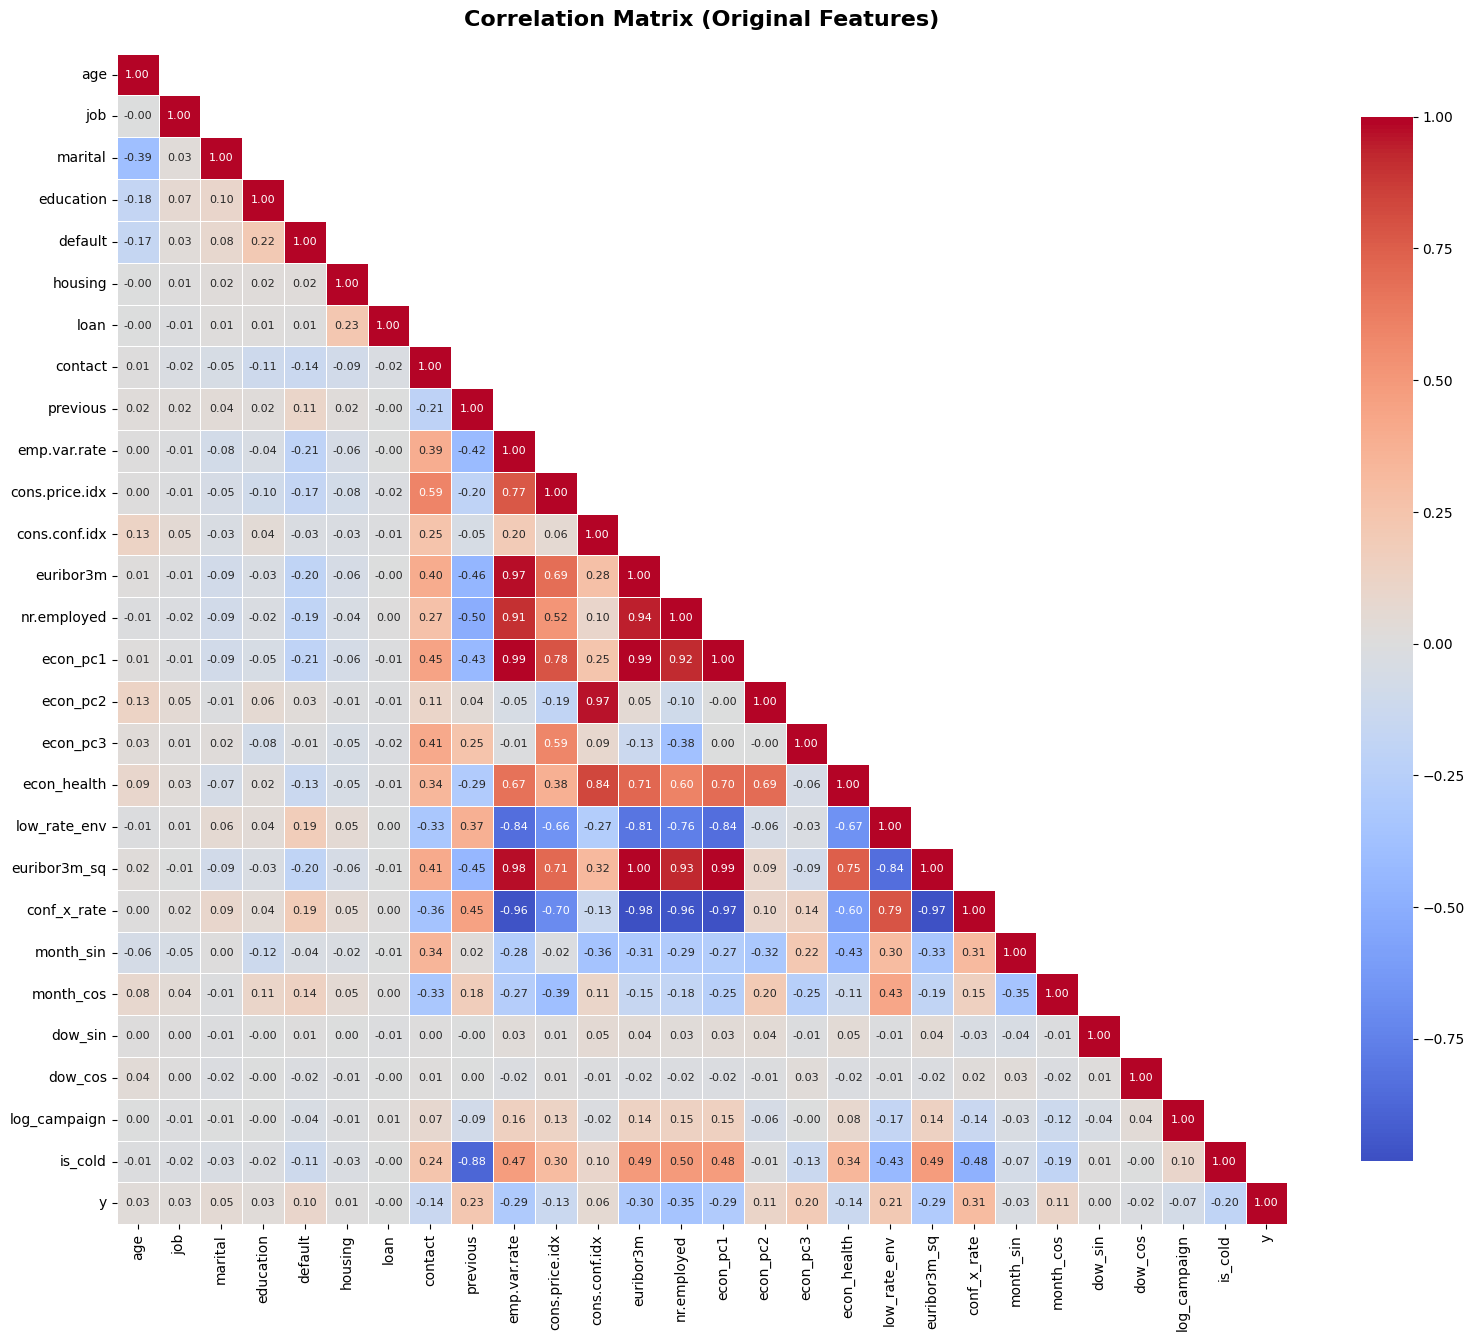


🔍 CORRELATION ANALYSIS & MULTICOLLINEARITY REDUCTION

📈 Top 10 features by |correlation| with target:
  nr.employed: 0.3497
  conf_x_rate: 0.3066
  euribor3m: 0.3032
  emp.var.rate: 0.2937
  econ_pc1: 0.2886
  euribor3m_sq: 0.2876
  previous: 0.2298
  low_rate_env: 0.2115
  econ_pc3: 0.1957
  is_cold: 0.1951

⚠️  Found 29 highly correlated pairs (|r| > 0.7):
     feature_1      feature_2  correlation  corr_with_y_1  corr_with_y_2         keep           drop
      previous        is_cold    -0.876529       0.229759       0.195115     previous        is_cold
  emp.var.rate cons.price.idx     0.773923       0.293690       0.132520 emp.var.rate cons.price.idx
  emp.var.rate      euribor3m     0.972154       0.293690       0.303174    euribor3m   emp.var.rate
  emp.var.rate    nr.employed     0.906313       0.293690       0.349729  nr.employed   emp.var.rate
  emp.var.rate       econ_pc1     0.990408       0.293690       0.288599 emp.var.rate       econ_pc1
  emp.var.rate   low_rate_env   

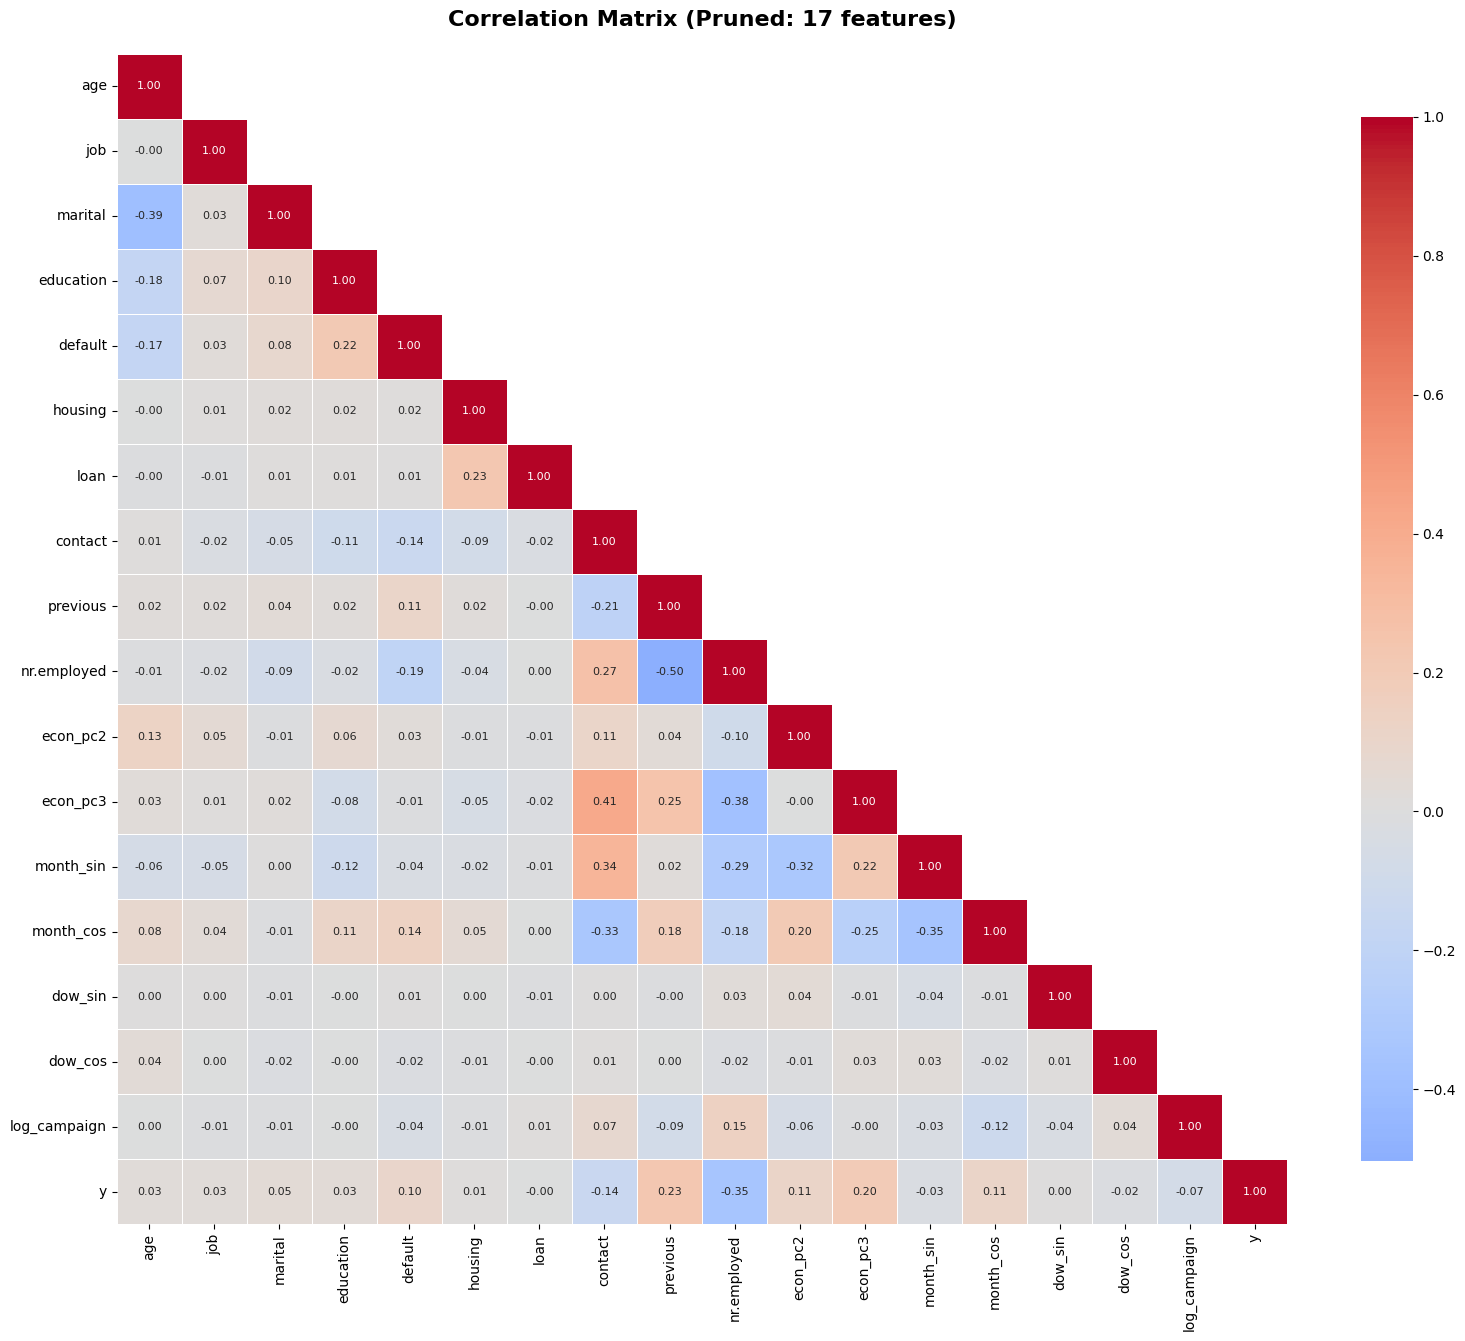


📋 MULTICOLLINEARITY REDUCTION SUMMARY
  Correlation threshold: |r| > 0.7
  High-corr pairs found: 29
  Features dropped: 10
  Original feature count: 27
  Final feature count: 17


In [9]:
# ============================================================
# CELL 8: CORRELATION ANALYSIS & PRUNING
# ============================================================
X_train_pruned, X_test_pruned, analyzer = analyze_and_prune_features(
    X_train_eng, X_test_eng, y_train,
    threshold=0.7,
    plot=True
)

    


🔧 CALIBRATED LR STAGE: Hyperparameter Tuning + Calibration

📏 Scaling features...

🔍 HYPERPARAMETER TUNING (F2-Score: Recall-Favoring)
   Testing 64 combinations...

✅ Best Parameters:
   C: 0.1
   class_weight: balanced
   max_iter: 1000
   penalty: l2
   solver: liblinear
   Best CV F2-Score: 0.5124

🔧 PROBABILITY CALIBRATION

📊 Uncalibrated Metrics:
   Brier: 0.179078
   Log Loss: 0.550667
   ECE: 0.295098

   Fitting Platt Scaling (sigmoid)...
   Fitting Isotonic Regression...

🏆 Selected Calibration: isotonic
   Brier: 0.179078 → 0.082626 (-53.9%)
   ECE: 0.295098 → 0.001917 (-99.4%)

🎯 Optimizing threshold on validation set...
   Optimal threshold: 0.0994
   F2-score: 0.5241

📈 EVALUATING CALIBRATED LR (threshold=0.0994)

📊 Test Performance:
   ACCURACY: 0.7711
   PRECISION: 0.2867
   RECALL: 0.6940
   F1: 0.4058
   F2: 0.5404
   ROC_AUC: 0.7835
   BRIER: 0.0808
   ECE: 0.0082

📊 Confusion Matrix:
   TN: 5708, FP: 1602
   FN: 284, TP: 644


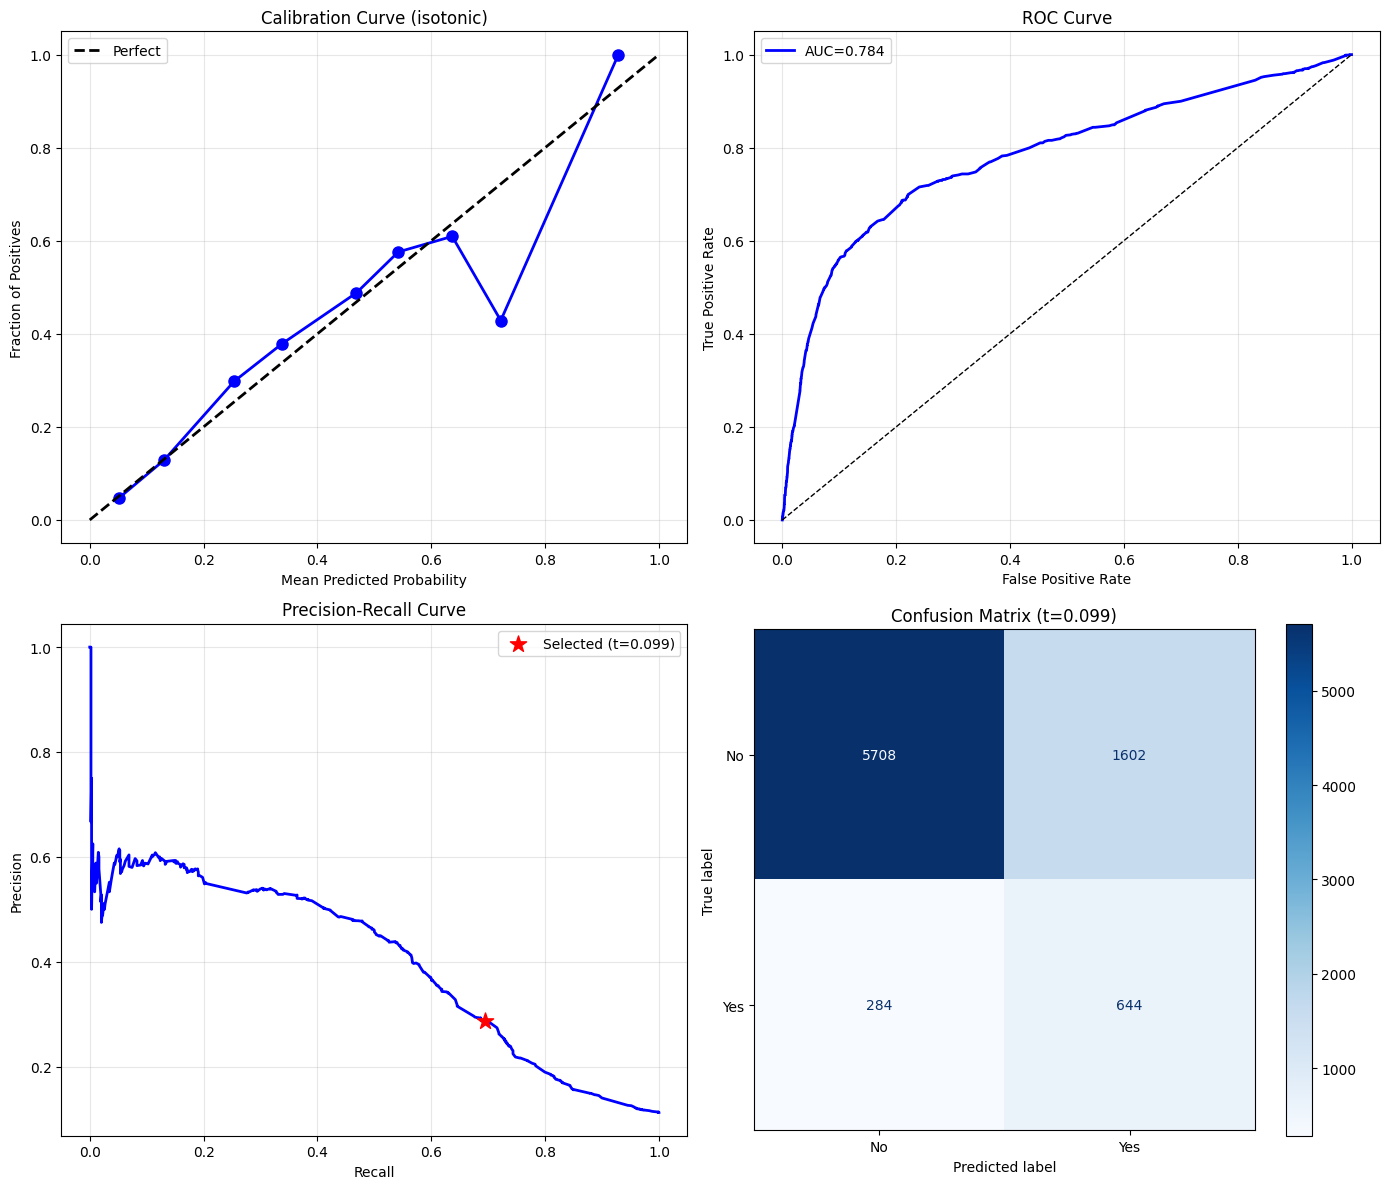


📊 Feature Importance (Top 10):
       feature  coefficient  abs_coefficient
  emp.var.rate    -1.174226         1.174226
cons.price.idx     0.678706         0.678706
       contact    -0.477635         0.477635
     euribor3m     0.303863         0.303863
   nr.employed    -0.259430         0.259430
 cons.conf.idx     0.237313         0.237313
       default     0.134195         0.134195
      campaign    -0.096539         0.096539
       marital     0.090458         0.090458
           age     0.067837         0.067837

💾 Saved: ./models/lr\lr_calibrated_20260129_153642.joblib

🎯 Calibrated LR Stage complete


In [10]:
# ============================================================
# CELL 9: HYPERPARAMETER TUNING + CALIBRATION
# ============================================================
# Split train into train + validation for threshold optimization
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    test_size=0.15,
    stratify=y_train,
    random_state=42
)

calibrated_stage, calibrated_metrics = train_calibrated_lr_stage(
    X_train_sub, X_val, X_test,
    y_train_sub, y_val, y_test,
    save=True,
    output_dir="./models/lr"
)

# Stage 2: GLASS-BRW


🌲 RF LIFT ANALYSIS

🌲 Training Random Forest...
   Accuracy: 0.8521
   ROC-AUC:  0.8103

📊 FEATURE IMPORTANCE ANALYSIS

🔝 Gini Importance (Top 15):
       Feature  Gini_Importance
   nr.employed         0.261031
     euribor3m         0.225992
  emp.var.rate         0.153042
 cons.conf.idx         0.075378
cons.price.idx         0.053548
         month         0.042058
           age         0.038792
      previous         0.027214
      campaign         0.022045
       contact         0.022005
   day_of_week         0.019182
     education         0.015418
           job         0.015289
       default         0.011761
       marital         0.007571

🔀 Computing Permutation Importance...

🔝 Permutation Importance (Top 15):
       Feature  Perm_Importance  Perm_Std
   nr.employed         0.017433  0.003620
  emp.var.rate         0.016936  0.003570
     euribor3m         0.015375  0.002487
       contact         0.011473  0.002461
 cons.conf.idx         0.004974  0.001763
cons.price.id

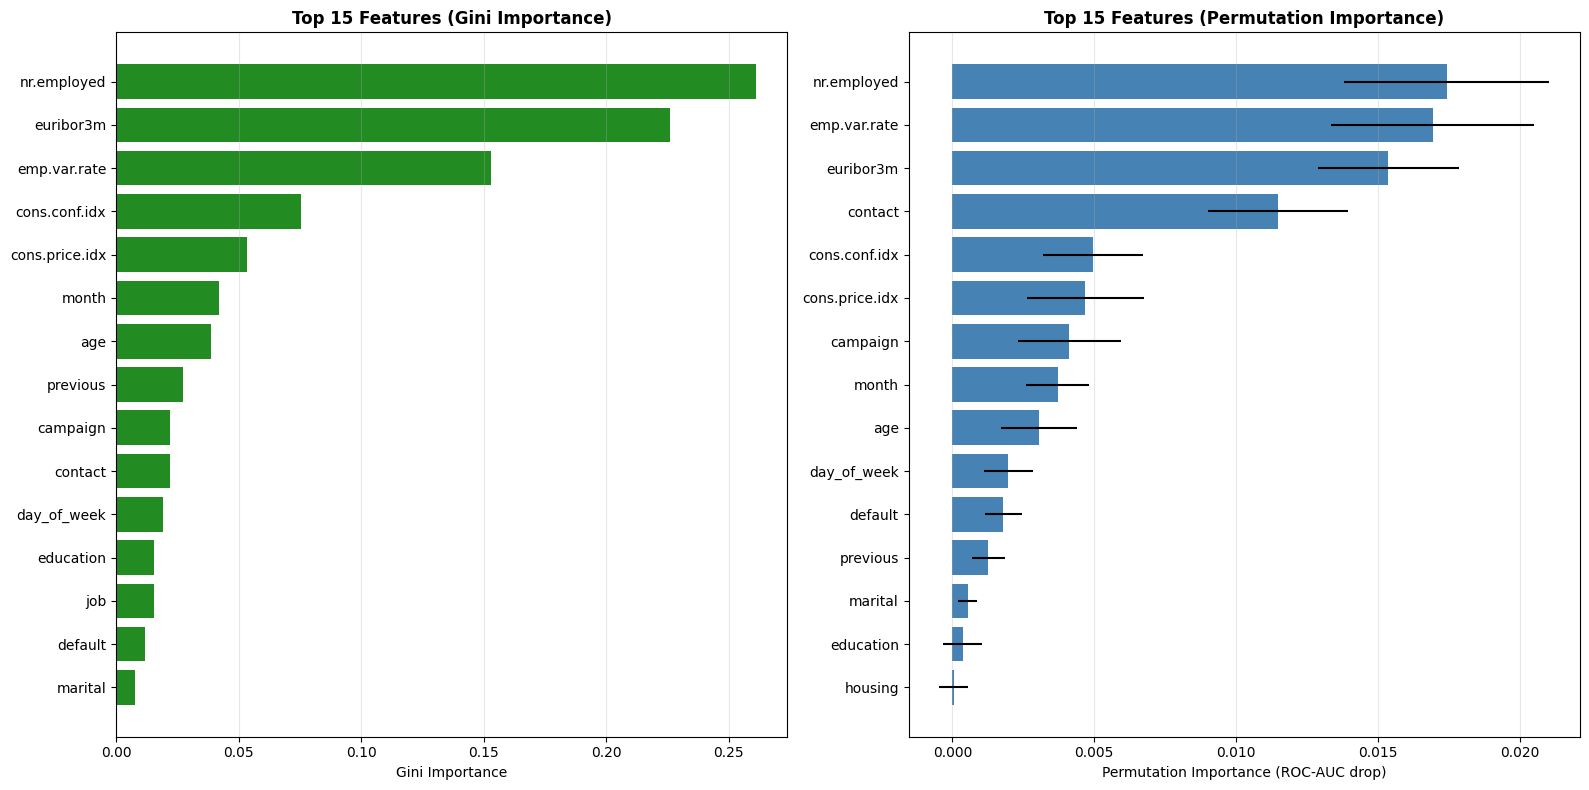

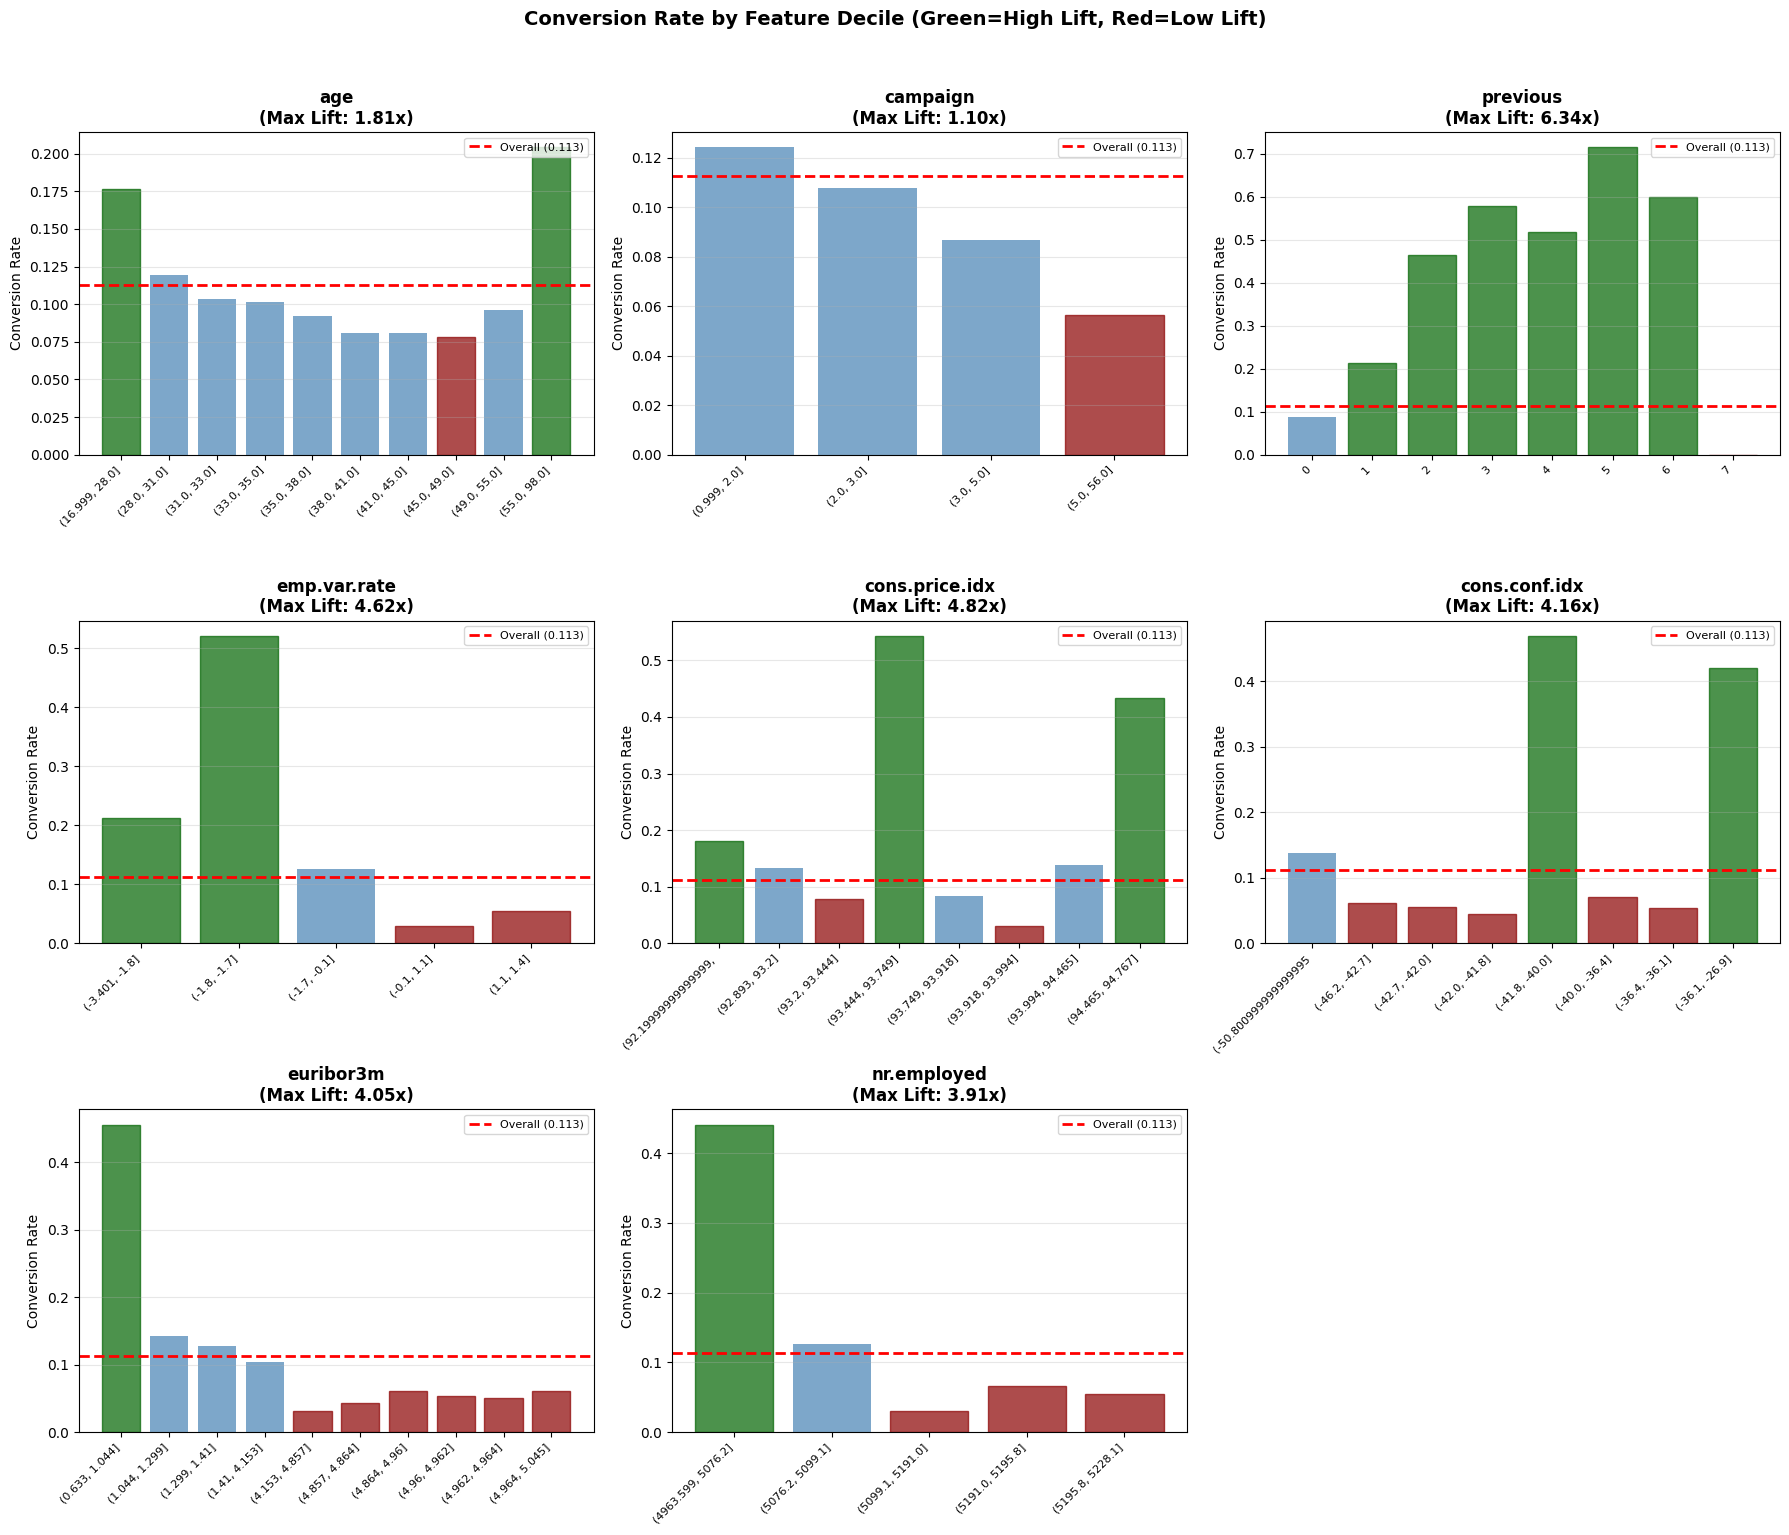


🎯 Use these insights to define GLASS-BRW binning


In [11]:
# ============================================================
# CELL 9: RF LIFT ANALYSIS
# ============================================================
# Use raw features (before LR engineering)
X_rf_train = df_proc.drop(columns=['y']).loc[GLOBAL_SPLIT['train_idx']]
X_rf_test = df_proc.drop(columns=['y']).loc[GLOBAL_SPLIT['test_idx']]
y_rf_train = df_proc['y'].loc[GLOBAL_SPLIT['train_idx']]
y_rf_test = df_proc['y'].loc[GLOBAL_SPLIT['test_idx']]

# Drop leaky features
leaky = ['duration', 'pdays', 'poutcome']
X_rf_train = X_rf_train.drop(columns=[f for f in leaky if f in X_rf_train.columns])
X_rf_test = X_rf_test.drop(columns=[f for f in leaky if f in X_rf_test.columns])

# Run lift analysis
rf_analyzer, rf_analysis = analyze_rf_lift(
    X_rf_train, y_rf_train,
    X_rf_test, y_rf_test,
    GLOBAL_SPLIT,
    plot=True
)

In [12]:
# ============================================================
# CELL 10: GLASS-BRW FEATURE ENGINEERING
# ============================================================
BRW_DATA = prepare_brw_data(df_proc, GLOBAL_SPLIT)


📐 PREPARING BRW DATA
🔧 GLASS-BRW FEATURE ENGINEERING (Lift-Based)

✅ Engineered 58 binary features
   Features: ['previous_zero', 'previous_low', 'previous_mid', 'previous_high', 'nr_employed_low', 'nr_employed_mid', 'nr_employed_high', 'euribor_low', 'euribor_mid', 'euribor_high', 'emp_var_very_neg', 'emp_var_neg', 'emp_var_pos', 'cpi_low', 'cpi_sweet_spot', 'cpi_high', 'cpi_mid', 'cci_very_low', 'cci_sweet_spot', 'cci_high', 'cci_mid', 'month_hot', 'month_warm', 'month_neutral', 'month_cold', 'contact_cellular', 'contact_telephone', 'age_young', 'age_prime', 'age_mid', 'age_senior', 'campaign_first', 'campaign_moderate', 'campaign_heavy', 'job_high_lift', 'job_above_avg', 'job_neutral', 'job_low_lift', 'marital_single', 'marital_married', 'marital_divorced', 'marital_unknown', 'education_high', 'education_mid', 'education_low', 'dow_midweek', 'dow_edges', 'default_no', 'default_unknown', 'housing_yes', 'housing_no', 'loan_yes', 'loan_no', 'econ_favorable', 'econ_unfavorable', 'prosp

🌲 RF STAGE: Hyperparameter Tuning (BRW Features)

📊 Data:
   Train: (32950, 58) | Positives: 3712 (0.1127)
   Test:  (8238, 58) | Positives: 928 (0.1126)

🔧 Hyperparameter Search:
   Iterations: 60
   CV: 5-fold stratified
   Scoring: F2 (recall-favoring)

   Running search...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✅ Best CV F2 Score: 0.5410

📊 Best Hyperparameters:
   bootstrap           : True
   class_weight        : balanced_subsample
   criterion           : gini
   max_depth           : 8
   max_features        : 0.3
   min_samples_leaf    : 26
   min_samples_split   : 52
   n_estimators        : 275

📊 Performance:

🔵 TRAINING SET:
   Accuracy: 0.8543
   Precision: 0.4021
   Recall: 0.6021
   F1-Score: 0.4822
   F2-Score: 0.5476
   ROC-AUC: 0.8190

🟢 TEST SET:
   Accuracy: 0.8597
   Precision: 0.4174
   Recall: 0.6207
   F1-Score: 0.4991
   F2-Score: 0.5656
   ROC-AUC: 0.8037

🔍 OVERFITTING ANALYSIS:
   Accuracy: Gap=-0.0053 ✅
   F1-Score: Gap=-0.0169 ✅
 

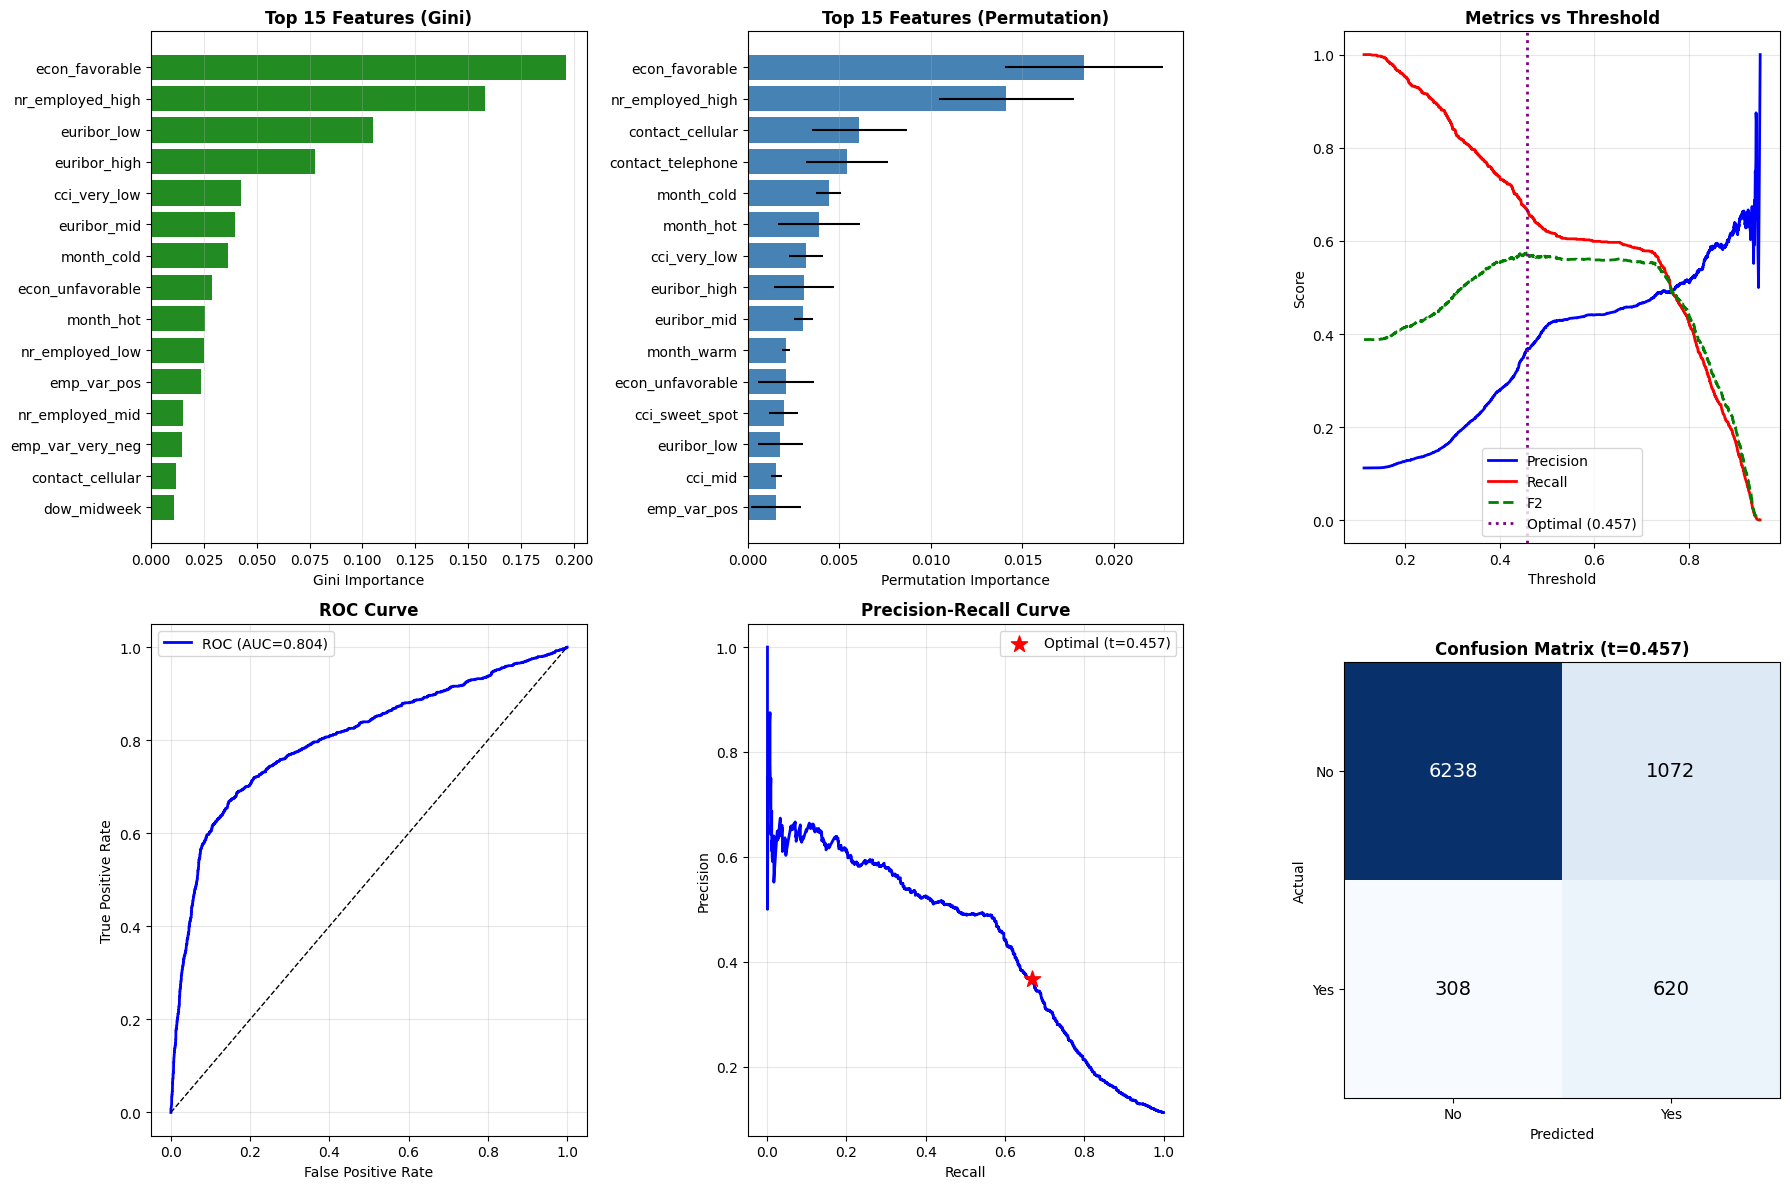


💾 Saved:
   Model:    ./models/rf\rf_model_20260129_154245.pkl
   Ensemble: ./models/rf\rf_ensemble_20260129_154245.joblib

🎯 RF Stage complete


In [13]:
rf_stage, rf_metrics = train_rf_stage(
    BRW_DATA['X_eng_train'],
    BRW_DATA['X_eng_test'],
    BRW_DATA['y_eng_train'],
    BRW_DATA['y_eng_test'],
    save=True,
    output_dir="./models/rf"
)

In [30]:
# ============================================================
# CELL: PREPARE SEGMENTS AND SEGMENT BUILDER
# ============================================================
print("Preparing segment builder and discretizing data...")

# Create segment builder instance (used by both generator and evaluator)
segment_builder = BankSegmentBuilder()

# Prepare training segments
train_segments_brw = prepare_segments(
    BRW_DATA['X_eng_train'], 
    print_summary=True
)

# Prepare test segments  
test_segments_brw = prepare_segments(
    BRW_DATA['X_eng_test'], 
    print_summary=False
)

# Get labels
y_train_brw = BRW_DATA["y_eng_train"]
y_test_brw = BRW_DATA["y_eng_test"]

print(f"✅ Segments prepared")
print(f"   Training samples: {len(train_segments_brw)}")
print(f"   Test samples: {len(test_segments_brw)}")

Preparing segment builder and discretizing data...
📋 SEGMENT FEATURES PREPARED
   Features: 58
   Samples: 32950

⚠️  Low coverage features (4):
   prospect_hot: 0.77%
   previous_mid: 0.71%
   marital_unknown: 0.20%
   previous_high: 0.06%

✅ Segment features validated
✅ Segments prepared
   Training samples: 32950
   Test samples: 8238


In [31]:
# ============================================================
# CELL: INITIALIZE RULE GENERATOR
# ============================================================
print("\nInitializing rule generator...")

rule_generator = RuleGenerator(
    # Support thresholds (Depth 3)
    min_support_pass1=270,
    min_support_pass2=100,
    
    # Complexity bounds
    max_complexity=3,
    min_complexity=1,
    
    # Pass 1: NOT_SUBSCRIBE (Precision-focused filters)
    max_coverage_not_subscribe=1.00,
    min_precision_not_subscribe=0.25,
    max_precision_not_subscribe=1.00,
    max_subscriber_leakage_rate=0.99,
    max_subscriber_leakage_absolute=999,
    
    # Pass 2: SUBSCRIBE (Recall-focused detectors)
    max_coverage_subscribe=0.99,
    min_precision_subscribe=0.25,
    max_precision_subscribe=1.00,
    min_recall_subscribe=0.15,
    max_recall_subscribe=0.99,
    
    # Depth 2: Light structural pruning
    max_leakage_rate_depth2=0.75,
    max_leakage_fraction_depth2=0.65,
    
    # Beam search
    beam_width=100,
    
    # Diversity
    diversity_penalty=0.3,
    max_feature_reuse_pass1=3,
    max_feature_reuse_pass2=3,
    
    # Segment builder (use the one we created above)
    segment_builder=segment_builder,
    
    # Tier1 features
    tier1_prefixes=(
        'previous', 'nr_employed', 'euribor', 'emp_var', 'cpi', 'cci',
        'month', 'contact', 'age', 'campaign', 'job', 'marital',
        'education', 'dow', 'default', 'housing', 'loan',
        'econ', 'prospect',
    ),
    
    # Random Forest (use from rf_stage)
    rf_model=rf_stage.model,
    feature_importance_threshold=0.00,
    
    # Diagnostic logging
    verbose_rejection_logging=True,
    max_rejection_logs_per_constraint=50,
    verbose_acceptance_logging=True,
    max_acceptance_logs_per_depth=25,
)

print("✅ Rule generator initialized")


Initializing rule generator...
🧩 RuleGenerator initialized with 58 segment features
✅ Rule generator initialized


In [32]:
# ============================================================
# CELL: GENERATE CANDIDATE RULES
# ============================================================
print("\n" + "="*60)
print("GENERATING CANDIDATE RULES")
print("="*60)

candidate_rules = rule_generator.generate_candidates(
    segments_df=train_segments_brw,
    y=y_train_brw
)

print(f"\n{'='*60}")
print("✅ Generated {len(candidate_rules)} candidate rules")
print(f"   Pass 1 (NOT_SUBSCRIBE): {sum(1 for r in candidate_rules if r.predicted_class == 0)} rules")
print(f"   Pass 2 (SUBSCRIBE): {sum(1 for r in candidate_rules if r.predicted_class == 1)} rules")
print("="*60)



GENERATING CANDIDATE RULES

Top 10 RF features by importance:
  econ_favorable: 0.1965
  nr_employed_high: 0.1579
  euribor_low: 0.1051
  euribor_high: 0.0774
  cci_very_low: 0.0424
  euribor_mid: 0.0398
  month_cold: 0.0364
  econ_unfavorable: 0.0288
  month_hot: 0.0257
  nr_employed_low: 0.0249

Using 58/58 features above threshold

SEQUENTIAL RULE GENERATION WITH DEPTH-STAGED CONSTRAINTS
  Beam width: 100
  Complexity: 1–3
  Total samples: 32950
  Total subscribers: 3712

  ✅ DEPTH-STAGED CONSTRAINT STRATEGY:
    • Depth 1: ONLY structural validity
    • Depth 2: Light pruning ONLY
    • Depth 3: Quality constraints (NO OVERLAP - ILP handles)

DEPTH 1: SEED GENERATION
  🚫 NO support constraints at this depth
  🚫 NO precision/recall constraints at this depth

DEPTH 1 SUMMARY:
Total feature-label pairs considered: 116
Rejected - duplicate base features: 0

Pass 1 (NOT_SUBSCRIBE):
  Accepted: 116

Pass 2 (SUBSCRIBE):
  Accepted: 116

Depth 1 seeds (structural validity only):
  Pass 1 

In [33]:
# ============================================================
# CELL: PREPARE VALIDATION DATA (IF NOT ALREADY DONE)
# ============================================================
# NOTE: Skip this cell if you already have X_val_brw and y_val_brw defined
# This assumes you want to use test data as validation

print("\nPreparing validation data...")

X_val_brw = BRW_DATA['X_eng_test']
y_val_brw = BRW_DATA['y_eng_test']

print(f"✅ Validation data prepared")
print(f"   Samples: {len(X_val_brw)}")
print(f"   Subscribers: {(y_val_brw == 1).sum()}")
print(f"   Non-subscribers: {(y_val_brw == 0).sum()}")


Preparing validation data...
✅ Validation data prepared
   Samples: 8238
   Subscribers: 928
   Non-subscribers: 7310


In [34]:
# ============================================================
# CELL: INITIALIZE RULE EVALUATOR
# ============================================================
print("\nInitializing rule evaluator...")

rule_evaluator = RuleEvaluator(
    segment_builder=segment_builder,  # Use same segment_builder
    min_support=30,
    n_bootstrap=3,
    tier1_prefixes=(
        'previous', 'nr_employed', 'euribor', 'emp_var', 'cpi', 'cci',
        'month', 'contact', 'age', 'campaign', 'job', 'marital',
        'education', 'dow', 'default', 'housing', 'loan',
        'econ', 'prospect',
    ),
)

print("✅ Rule evaluator initialized")



Initializing rule evaluator...
✅ Rule evaluator initialized


In [35]:
# ============================================================
# CELL: EVALUATE CANDIDATE RULES
# ============================================================
print("\n" + "="*60)
print("EVALUATING CANDIDATE RULES ON VALIDATION DATA")
print("="*60)

evaluated_rules = rule_evaluator.evaluate_candidates(
    candidates=candidate_rules,
    X_val=X_val_brw,
    y_val=y_val_brw,
    rf_model=rf_stage.model  # Use same RF model
)

print(f"\n{'='*60}")
print(f"✅ Evaluated {len(evaluated_rules)} rules")
print(f"   Pass 1 (NOT_SUBSCRIBE): {sum(1 for r in evaluated_rules if r.predicted_class == 0)} rules")
print(f"   Pass 2 (SUBSCRIBE): {sum(1 for r in evaluated_rules if r.predicted_class == 1)} rules")
print("="*60)


EVALUATING CANDIDATE RULES ON VALIDATION DATA

Evaluating 400 candidate rules...
Evaluated 400 rules (filtered 0 low-coverage)

Pass 1 overlap diagnostics:
  Average Jaccard: 0.824
  Maximum Jaccard: 1.000
  Rules with >0.5 overlap: 19900 / 19900

Pass 2 overlap diagnostics:
  Average Jaccard: 0.756
  Maximum Jaccard: 1.000
  Rules with >0.5 overlap: 17819 / 19900

✅ Evaluated 400 rules
   Pass 1 (NOT_SUBSCRIBE): 200 rules
   Pass 2 (SUBSCRIBE): 200 rules


In [40]:
# ============================================================
# CELL: INITIALIZE ILP RULE SELECTOR
# ============================================================
print("Initializing ILP rule selector...")

ilp_selector = ILPRuleSelector(
    # Pass 1 constraints
    min_pass1_rules=5,
    max_pass1_rules=12,
    min_precision_pass1=0.25,
    max_precision_pass1=1.00,
    max_subscriber_leakage_rate_pass1=0.15,
    max_subscriber_leakage_absolute_pass1=150,
    max_base_reuse_pass1=None,  # None = use max_feature_usage
    min_coverage_pass1=0.005,  # Min 0.5% coverage
    max_coverage_pass1=0.75,   # Max 75% coverage
    
    # Pass 2 constraints
    min_pass2_rules=5,
    max_pass2_rules=12,
    min_precision_pass2=0.05,
    max_precision_pass2=1.00,
    min_recall_pass2=0.10,
    max_recall_pass2=0.99,
    max_base_reuse_pass2=None,  # None = use max_feature_usage
    min_coverage_pass2=0.005,  # Min 0.5% coverage
    max_coverage_pass2=0.35,   # Max 35% coverage
    
    # Shared parameters
    max_feature_usage=40,           # Max rules per base feature
    lambda_rf_uncertainty=0.15,    # RF uncertainty penalty
    lambda_rf_misalignment=0.08,   # RF misalignment penalty
    diversity_weight=0.33,         # Diversity weight in scoring
    
    # Novelty constraints (lowered from 50% to 20%)
    min_novelty_ratio_pass1=0.20,  # 20% min novelty for Pass 1
    min_novelty_ratio_pass2=0.20,  # 20% min novelty for Pass 2
    enable_novelty_constraints=True,  # Enable pairwise constraints
    
    # Greedy fallback controls
    min_novelty_greedy=0.15,            # 15% min novelty for greedy
    greedy_novelty_weight=0.5,          # Novelty weight in greedy scoring
    greedy_hard_novelty_cutoff=True,    # HARD cutoff (must add new samples)
    min_absolute_new_samples=30,        # Min 30 new samples required
    
    # Tier1 features (same as rule_generator and rule_evaluator)
    tier1_prefixes=(
        'previous', 'nr_employed', 'euribor', 'emp_var', 'cpi', 'cci',
        'month', 'contact', 'age', 'campaign', 'job', 'marital',
        'education', 'dow', 'default', 'housing', 'loan',
        'econ', 'prospect',
    ),
)

print("✅ ILP rule selector initialized")

Initializing ILP rule selector...
✅ ILP rule selector initialized


In [41]:
# ============================================================
# CELL: SELECT OPTIMAL RULE SUBSET
# ============================================================
print("\n" + "="*80)
print("SELECTING OPTIMAL RULE SUBSET VIA ILP")
print("="*80)

selected_rules = ilp_selector.select_rules(
    evaluated_rules=evaluated_rules,
    y_val=y_val_brw  # Required for Pass 1 leakage computation
)

# Extract results
pass1_rules = selected_rules["pass1_rules"]
pass2_rules = selected_rules["pass2_rules"]

print(f"\n{'='*80}")
print("✅ ILP SELECTION COMPLETE")
print(f"   Pass 1 (NOT_SUBSCRIBE): {len(pass1_rules)} rules selected")
print(f"   Pass 2 (SUBSCRIBE): {len(pass2_rules)} rules selected")
print("="*80)


SELECTING OPTIMAL RULE SUBSET VIA ILP

🧮 ILP RULE SELECTION

📊 Configuration:
   Novelty constraints enabled: True
   Pass 1 min novelty (ILP): 20%
   Pass 2 min novelty (ILP): 20%
   Greedy min novelty: 15%
   Greedy hard cutoff: True
   Min absolute new samples: 30
   Pass 1 coverage: [0.005, 0.75]
   Pass 2 coverage: [0.005, 0.35]

Candidate split:
  Pass 1 candidates: 200
  Pass 2 candidates: 200

🧪 ENTERING ILP OPTIMIZATION: Pass 1 (NOT_SUBSCRIBE)
--------------------------------------------------------------------------------
Total incoming candidates: 200

🔎 Pass 1 Quality Gate Diagnostics
   Candidates:              200
   Passed:                  0
   Rejected:                200
   Constraints: prec=[0.25, 1.0], cov=[0.005, 0.75]
   Rejection breakdown:
     leakage_rate: 200
     leakage_abs: 200
     coverage_high: 43
  ✅ Passed gates: 0/200
  ❌ Rejected: 200/200
  ⚠️  No valid candidates after quality gates!

🧪 ENTERING ILP OPTIMIZATION: Pass 2 (SUBSCRIBE)
---------------

In [45]:
# ============================================================
# CELL 14: GLASS-BRW CONTROLLER (CLEANED UP)
# ============================================================
class GLASS_BRW:
    """
    GLASS-BRW: Globally-optimized Locally Adaptive Sparse Sequential 
    rule-based classifier with Bootstrap-validated Rule Weighting.
    
    Three-stage pipeline:
    1. RuleGenerator: Depth-staged beam search with RF guidance
    2. RuleEvaluator: Bootstrap validation on held-out data
    3. ILPRuleSelector: Global optimization for final rule subset
    
    Sequential execution:
    - Pass 1 (NOT_SUBSCRIBE) executes first
    - Pass 2 (SUBSCRIBE) executes on Pass 1 survivors
    - Abstain if no rule matches
    """
    
    def __init__(
        self,
        # Support thresholds (Depth 3)
        min_support_pass1=275,
        min_support_pass2=125,
        # Depth 2: Light structural pruning
        max_leakage_rate_depth2=0.75,
        max_leakage_fraction_depth2=0.65,
        # Overlap suppression (Depth 3)
        max_jaccard_overlap=0.35,
        max_high_overlap_rules=2,
        # Pass 1: NOT_SUBSCRIBE (Precision-focused)
        min_pass1_rules=5,
        max_pass1_rules=10,
        min_precision_not_subscribe=0.50,
        max_precision_not_subscribe=1.00,
        max_subscriber_leakage_rate=0.10,
        max_subscriber_leakage_absolute=200,
        # Pass 2: SUBSCRIBE (Recall-focused)
        min_pass2_rules=5,
        max_pass2_rules=8,
        min_precision_subscribe=0.50,
        max_precision_subscribe=1.00,
        min_recall_subscribe=0.25,
        max_recall_subscribe=0.99,
        # ILP novelty constraints
        min_novelty_ratio_pass1=0.20,
        min_novelty_ratio_pass2=0.20,
        enable_novelty_constraints=True,
        # Shared constraints
        max_complexity=3,
        mode="strict",
        rf_model=None,
        segment_builder=None,  # FIXED: Now accepts segment_builder
        diversity_weight=0.3,
        max_feature_reuse_pass1=None,
        max_feature_reuse_pass2=None,
    ):
        """Initialize GLASS-BRW with hyperparameters."""
        
        # Store parameters
        self.mode = mode
        self.min_support_pass1 = min_support_pass1
        self.min_support_pass2 = min_support_pass2
        self.max_leakage_rate_depth2 = max_leakage_rate_depth2
        self.max_leakage_fraction_depth2 = max_leakage_fraction_depth2
        self.max_jaccard_overlap = max_jaccard_overlap
        self.max_high_overlap_rules = max_high_overlap_rules
        self.min_pass1_rules = min_pass1_rules
        self.max_pass1_rules = max_pass1_rules
        self.min_precision_not_subscribe = min_precision_not_subscribe
        self.max_precision_not_subscribe = max_precision_not_subscribe
        self.max_subscriber_leakage_rate = max_subscriber_leakage_rate
        self.max_subscriber_leakage_absolute = max_subscriber_leakage_absolute
        self.min_pass2_rules = min_pass2_rules
        self.max_pass2_rules = max_pass2_rules
        self.min_precision_subscribe = min_precision_subscribe
        self.max_precision_subscribe = max_precision_subscribe
        self.min_recall_subscribe = min_recall_subscribe
        self.max_recall_subscribe = max_recall_subscribe
        self.min_novelty_ratio_pass1 = min_novelty_ratio_pass1
        self.min_novelty_ratio_pass2 = min_novelty_ratio_pass2
        self.enable_novelty_constraints = enable_novelty_constraints
        self.max_complexity = max_complexity
        self.diversity_weight = diversity_weight
        self.max_feature_reuse_pass1 = max_feature_reuse_pass1
        self.max_feature_reuse_pass2 = max_feature_reuse_pass2
        
        # FIXED: Use provided segment_builder or create new one
        self.segment_builder = segment_builder if segment_builder is not None else BankSegmentBuilder()
        
        # Initialize pipeline components
        self.rule_generator = RuleGenerator(
            min_support_pass1=min_support_pass1,
            min_support_pass2=min_support_pass2,
            max_leakage_rate_depth2=max_leakage_rate_depth2,
            max_leakage_fraction_depth2=max_leakage_fraction_depth2,
            max_complexity=max_complexity,
            min_complexity=1,
            beam_width=100,
            # Pass 1 constraints
            max_coverage_not_subscribe=1.00,
            min_precision_not_subscribe=min_precision_not_subscribe,
            max_precision_not_subscribe=max_precision_not_subscribe,
            max_subscriber_leakage_rate=max_subscriber_leakage_rate,
            max_subscriber_leakage_absolute=max_subscriber_leakage_absolute,
            # Pass 2 constraints
            max_coverage_subscribe=0.99,
            min_precision_subscribe=min_precision_subscribe,
            max_precision_subscribe=max_precision_subscribe,
            min_recall_subscribe=min_recall_subscribe,
            max_recall_subscribe=max_recall_subscribe,
            # Diversity
            diversity_penalty=0.3,
            max_feature_reuse_pass1=max_feature_reuse_pass1 or 3,
            max_feature_reuse_pass2=max_feature_reuse_pass2 or 3,
            # Segment builder
            segment_builder=self.segment_builder,
            # RF model
            rf_model=rf_model,
            feature_importance_threshold=0.00,
        )
        
        self.rule_evaluator = RuleEvaluator(
            segment_builder=self.segment_builder,
            min_support=min(min_support_pass1, min_support_pass2) // 2,
            n_bootstrap=3,
        )
        
        self.ilp_selector = ILPRuleSelector(
            # Pass 1
            min_pass1_rules=min_pass1_rules,
            max_pass1_rules=max_pass1_rules,
            min_precision_pass1=min_precision_not_subscribe,
            max_precision_pass1=max_precision_not_subscribe,
            max_subscriber_leakage_rate_pass1=max_subscriber_leakage_rate,
            max_subscriber_leakage_absolute_pass1=max_subscriber_leakage_absolute,
            max_base_reuse_pass1=max_feature_reuse_pass1,
            # Pass 2
            min_pass2_rules=min_pass2_rules,
            max_pass2_rules=max_pass2_rules,
            min_precision_pass2=min_precision_subscribe,
            max_precision_pass2=max_precision_subscribe,
            min_recall_pass2=min_recall_subscribe,
            max_recall_pass2=max_recall_subscribe,
            max_base_reuse_pass2=max_feature_reuse_pass2,
            # Shared
            diversity_weight=diversity_weight,
            # Novelty constraints
            min_novelty_ratio_pass1=min_novelty_ratio_pass1,
            min_novelty_ratio_pass2=min_novelty_ratio_pass2,
            enable_novelty_constraints=enable_novelty_constraints,
        )
        
        # State variables
        self.pass1_rules = []
        self.pass2_rules = []
        self.rf_model = rf_model
        self.is_fitted = False
    
    def fit(self, X_train, y_train, X_val, y_val, rf_model=None):
        """
        Train GLASS-BRW classifier.
        
        Pipeline:
        1. Discretize training data
        2. Generate candidate rules (beam search)
        3. Evaluate candidates on validation data
        4. Select optimal subset (ILP)
        5. Sort rules for execution
        
        Args:
            X_train: Training features
            y_train: Training labels
            X_val: Validation features
            y_val: Validation labels
            rf_model: Optional RF model (overrides init)
            
        Returns:
            self (for method chaining)
        """
        # Update RF model if provided
        if rf_model is not None:
            self.rf_model = rf_model
            self.rule_generator.rf_model = rf_model
        
        # Convert to canonical formats
        X_train = pd.DataFrame(X_train)
        X_val = pd.DataFrame(X_val)
        y_train = np.asarray(y_train)
        y_val = np.asarray(y_val)
        
        # Store training base rate
        self.training_base_rate = float(np.mean(y_train))
        
        # Discretize training data
        segments_train = self.segment_builder.assign_segments(X_train)
        
        # Generate candidate rules
        candidates = self.rule_generator.generate_candidates(segments_train, y_train)
        
        # Evaluate candidates
        evaluated = self.rule_evaluator.evaluate_candidates(
            candidates, X_val, y_val, rf_model=self.rf_model
        )
        
        # Select optimal subset
        selection = self.ilp_selector.select_rules(evaluated, y_val=y_val)
        
        # Sort rules for execution
        self.pass1_rules = sorted(
            selection["pass1_rules"], key=lambda r: r.precision, reverse=True
        )
        self.pass2_rules = sorted(
            selection["pass2_rules"], key=lambda r: r.recall, reverse=True
        )
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        """
        Predict labels using sequential first-match-wins semantics.
        
        Returns:
            (preds, conf, decisions) tuple
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted")
        
        X = pd.DataFrame(X)
        segments = self.segment_builder.assign_segments(X).astype(int)
        n = len(X)
        
        preds = np.full(n, ABSTAIN, dtype=int)
        conf = np.zeros(n, dtype=float)
        decisions = ["abstain"] * n
        
        for i in range(n):
            # Pass 1: NOT_SUBSCRIBE filters
            pass1_matched = False
            for r in self.pass1_rules:
                if all(segments.iloc[i][f] == v for f, v in r.segment):
                    preds[i] = NOT_SUBSCRIBE
                    conf[i] = float(r.precision)
                    decisions[i] = "pass1"
                    pass1_matched = True
                    break
            
            if pass1_matched:
                continue
            
            # Pass 2: SUBSCRIBE detectors
            for r in self.pass2_rules:
                if all(segments.iloc[i][f] == v for f, v in r.segment):
                    preds[i] = SUBSCRIBE
                    conf[i] = float(r.precision)
                    decisions[i] = "pass2"
                    break
        
        self.last_predictions = preds
        self.last_confidences = conf
        self.last_pass_decisions = decisions
        
        return preds, conf, decisions
    
    def predict_proba(self, X, base_rate=None):
        """
        Probabilistic output encoding.
        
        Returns:
            Array shape (n_samples, 2): [P(NOT_SUBSCRIBE), P(SUBSCRIBE)]
        """
        preds, conf, decisions = self.predict(X)
        n = len(preds)
        
        if base_rate is None:
            base_rate = getattr(self, 'training_base_rate', 0.117)
        
        probas = np.full((n, 2), [1 - base_rate, base_rate], dtype=float)
        
        for i in range(n):
            if decisions[i] == "pass1":
                probas[i, 1] = base_rate * (1 - conf[i])
                probas[i, 0] = 1 - probas[i, 1]
            elif decisions[i] == "pass2":
                probas[i, 1] = base_rate + (1 - base_rate) * conf[i]
                probas[i, 0] = 1 - probas[i, 1]
        
        return probas
    
    def get_coverage_stats(self, X, y):
        """Compute coverage and quality metrics."""
        preds, _, decisions = self.predict(X)
        y = np.asarray(y)
        
        covered = preds != ABSTAIN
        pass2 = np.array([d == "pass2" for d in decisions])
        
        return {
            "coverage": covered.mean(),
            "abstention": (~covered).mean(),
            "covered_precision": precision_score(
                y[pass2], preds[pass2], pos_label=SUBSCRIBE, zero_division=0
            ) if pass2.any() else 0.0,
            "covered_recall": recall_score(
                y, (preds == SUBSCRIBE).astype(int), pos_label=1, zero_division=0
            ),
        }
    
    def get_rule_summary(self):
        """Generate human-readable summary of learned rules."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted first")
        
        summary = []
        
        # Pass 1 rules
        for i, r in enumerate(self.pass1_rules, 1):
            summary.append({
                "rule_id": i,
                "pass": "Pass 1",
                "class": "NOT_SUBSCRIBE (0)",
                "segment": " AND ".join(f"{f}={v}" for f, v in r.segment),
                "precision": r.precision,
                "recall": r.recall,
                "coverage": r.coverage,
                "complexity": r.complexity,
                "rf_alignment": getattr(r, "rf_alignment", 0.0),
            })
        
        # Pass 2 rules
        for i, r in enumerate(self.pass2_rules, 1):
            summary.append({
                "rule_id": i,
                "pass": "Pass 2",
                "class": "SUBSCRIBE (1)",
                "segment": " AND ".join(f"{f}={v}" for f, v in r.segment),
                "precision": r.precision,
                "recall": r.recall,
                "coverage": r.coverage,
                "complexity": r.complexity,
                "rf_alignment": getattr(r, "rf_alignment", 0.0),
            })
        
        return summary

In [ ]:
# ============================================================
# CELL 15: GLASS-BRW MAIN PIPELINE 
# ============================================================

start_time = time.time()

# Create segment builder ONCE
segment_builder = BankSegmentBuilder()

# Initialize GLASS-BRW with segment_builder
glass = GLASS_BRW(
    # Support thresholds (Depth 3)
    min_support_pass1=125,
    min_support_pass2=75,
    # Depth 2 light pruning
    max_leakage_rate_depth2=1.00,
    max_leakage_fraction_depth2=1.00,
    # Overlap suppression (Depth 3)
    max_jaccard_overlap=0.40,
    max_high_overlap_rules=2,
    # Pass 1 (routing) - Depth 3
    min_pass1_rules=3,
    max_pass1_rules=6,
    min_precision_not_subscribe=0.25,
    max_precision_not_subscribe=1.00,
    max_subscriber_leakage_rate=0.17,
    max_subscriber_leakage_absolute=650,
    # Pass 2 (detection) - Depth 3
    min_pass2_rules=10,
    max_pass2_rules=20,
    min_precision_subscribe=0.30,
    max_precision_subscribe=1.00,
    min_recall_subscribe=0.03,
    max_recall_subscribe=0.75,
    # ILP novelty constraints
    min_novelty_ratio_pass1=0.03,
    min_novelty_ratio_pass2=0.02,
    enable_novelty_constraints=True,
    # Diversity constraints
    max_complexity=3,
    mode="strict",
    rf_model=rf_stage.model,
    segment_builder=segment_builder,
    diversity_weight=0.35,
    max_feature_reuse_pass1=None,
    max_feature_reuse_pass2=None,
)

# Fit the model - USE BRW DATA (binned features), not raw X_train!
# These should be your BRW_DATA variables from prepare_brw_data()
glass.fit(
    X_train=BRW_DATA["X_eng_train"],  # Binned BRW features
    y_train=BRW_DATA["y_eng_train"],
    X_val=BRW_DATA["X_eng_train"],    # Using train as val (or use X_val if you have it)
    y_val=BRW_DATA["y_eng_train"],
    rf_model=rf_stage.model
)

# ============================================================
# ANALYSIS (EXTRACTED TO PerformanceAnalyzer!)
# ============================================================
analyzer = PerformanceAnalyzer(glass, subscribe_label=SUBSCRIBE, abstain_label=ABSTAIN)

# Print rule quality
analyzer.print_rule_quality()

# Analyze predictions - USE BRW DATA!
train_out, test_out = analyzer.analyze_predictions(
    X_train=BRW_DATA["X_eng_train"],
    y_train=BRW_DATA["y_eng_train"],
    X_test=BRW_DATA["X_eng_test"],
    y_test=BRW_DATA["y_eng_test"]
)

# Runtime
end_time = time.time()
elapsed_time = end_time - start_time

print("\n" + "="*80)
print(f"⏱️  CELL RUNTIME: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print("="*80)

🧩 RuleGenerator initialized with 58 segment features

Top 10 RF features by importance:
  econ_favorable: 0.1965
  nr_employed_high: 0.1579
  euribor_low: 0.1051
  euribor_high: 0.0774
  cci_very_low: 0.0424
  euribor_mid: 0.0398
  month_cold: 0.0364
  econ_unfavorable: 0.0288
  month_hot: 0.0257
  nr_employed_low: 0.0249

Using 58/58 features above threshold

SEQUENTIAL RULE GENERATION WITH DEPTH-STAGED CONSTRAINTS
  Beam width: 100
  Complexity: 1–3
  Total samples: 32950
  Total subscribers: 3712

  ✅ DEPTH-STAGED CONSTRAINT STRATEGY:
    • Depth 1: ONLY structural validity
    • Depth 2: Light pruning ONLY
    • Depth 3: Quality constraints (NO OVERLAP - ILP handles)

DEPTH 1: SEED GENERATION
  🚫 NO support constraints at this depth
  🚫 NO precision/recall constraints at this depth

DEPTH 1 SUMMARY:
Total feature-label pairs considered: 116
Rejected - duplicate base features: 0

Pass 1 (NOT_SUBSCRIBE):
  Accepted: 116

Pass 2 (SUBSCRIBE):
  Accepted: 116

Depth 1 seeds (structural 

In [57]:
# ============================================================
# CELL 16: SAVE MODEL (SIMPLIFIED)
# ============================================================
from sklearn.metrics import precision_score, recall_score

# Get probabilities
train_proba = glass.predict_proba(BRW_DATA["X_eng_train"])
test_proba = glass.predict_proba(BRW_DATA["X_eng_test"])

# Save model
saver = ModelSaver(glass_model=glass)
filepath = saver.save_model(
    train_out=train_out,
    test_out=test_out,
    train_proba=train_proba,
    test_proba=test_proba,
    global_split=GLOBAL_SPLIT,
    y_test=BRW_DATA["y_eng_test"]
)

# Calculate metrics for final summary
test_pass1_mask = np.array([d == "pass1" for d in test_out["decisions"]])
test_pass2_mask = np.array([d == "pass2" for d in test_out["decisions"]])
y_test = BRW_DATA["y_eng_test"]
test_pred = test_out['pred']

is_subscriber = (y_test == SUBSCRIBE).values
total_subscribers = is_subscriber.sum()
pass1_blocked_subscribers = np.sum(test_pass1_mask & is_subscriber)
pass2_detected_subscribers = np.sum(test_pass2_mask & is_subscriber)
overall_recall = pass2_detected_subscribers / total_subscribers if total_subscribers > 0 else 0.0

# Covered metrics
covered = test_out['covered']
if covered.any():
    covered_precision = precision_score(
        y_test[covered], test_pred[covered], pos_label=SUBSCRIBE, zero_division=0
    )
    covered_recall = recall_score(
        y_test[covered], test_pred[covered], pos_label=SUBSCRIBE, zero_division=0
    )
else:
    covered_precision = 0.0
    covered_recall = 0.0

# Print final summary
saver.print_final_summary(
    test_out=test_out,
    pass1_blocked_subscribers=pass1_blocked_subscribers,
    total_subscribers=total_subscribers,
    overall_recall=overall_recall,
    covered_precision=covered_precision,
    covered_recall=covered_recall
)



💾 SAVING ARTIFACTS

✅ SAVED: ./models/glass_brw_20260129_200156.joblib

🔍 VERIFICATION:
   train_proba shape: (32950, 2)
   test_proba shape: (8238, 2)
   Rules: 13

📊 Sample predictions (first 10 test samples):
Sample   Pass         P(NOT_SUB)   P(SUB)       Pred         True  
----------------------------------------------------------------------
0        abstain      0.887344     0.112656     ABSTAIN(-1)  NOT(0) ✓
1        pass2        0.582752     0.417248     SUB(1)       NOT(0) ✗
2        pass2        0.481631     0.518369     SUB(1)       NOT(0) ✗
3        pass1        0.995370     0.004630     NOT_SUB(0)   NOT(0) ✓
4        pass2        0.582752     0.417248     SUB(1)       NOT(0) ✗
5        pass2        0.582752     0.417248     SUB(1)       NOT(0) ✗
6        pass1        0.994849     0.005151     NOT_SUB(0)   NOT(0) ✓
7        pass1        0.995370     0.004630     NOT_SUB(0)   NOT(0) ✓
8        pass2        0.481631     0.518369     SUB(1)       SUB(1) ✓
9        pass1    

In [58]:
# ============================================================
# CELL 17: RULE DIAGNOSTICS (SIMPLIFIED)
# ============================================================
# Create diagnostics analyzer
diagnostics = RuleDiagnostics(
    glass_model=glass,
    subscribe_label=SUBSCRIBE,
    not_subscribe_label=NOT_SUBSCRIBE,
    abstain_label=ABSTAIN
)

# Run full diagnostic analysis
rule_fn_df = diagnostics.run_full_diagnostics(
    X_test=BRW_DATA["X_eng_test"],
    y_test=BRW_DATA["y_eng_test"],
    test_pred=test_out["pred"],
    test_decisions=test_out["decisions"])


🔎 RULE-LEVEL FALSE NEGATIVE ANALYSIS (TEST SET)
  pass  rule_id                                                      segment  fires  false_negatives  true_negatives  fn_rate  precision_train  recall_train  true_positives
PASS 1        3               month_hot=0 AND age_prime=0 AND euribor_high=1   3246              132          3114.0 0.040665         0.954274      0.426124             NaN
PASS 1        1        econ_favorable=0 AND cci_sweet_spot=1 AND month_hot=0   3493              131          3362.0 0.037504         0.958897      0.453212             NaN
PASS 1        2            month_hot=0 AND contact_cellular=0 AND cci_high=0   2916              120          2796.0 0.041152         0.957782      0.380977             NaN
PASS 2        1                 emp_var_pos=0 AND month_cold=0 AND cci_mid=0   1430               14             NaN 0.009790         0.343262      0.521552           505.0
PASS 2        2           econ_favorable=1 AND month_cold=0 AND default_no=1   1324   

In [67]:
# ==============================================================
# DEPENDENCY SETUP: Stage 3 — Explainable Boosting Machine (EBM)
# ==============================================================

!pip install interpret -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 18.2 MB/s eta 0:00:00


🌳 CELL 18: EBM - Analysis-Driven Feature Engineering

🔧 18.1 DATA PREPARATION
--------------------------------------------------
Train shape: (32950, 17)
Class distribution - Train: [29238  3712]

🚫 18.2 DROPPING LEAKY FEATURES
--------------------------------------------------

🔧 18.3 EBM-NATIVE FEATURE ENGINEERING
--------------------------------------------------
   Creating macro_index from: ['nr.employed', 'euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']
   Features added: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'log_campaign', 'log_previous', 'macro_index', 'age_centered', 'age_squared', 'campaign_fatigue', 'has_previous']

🔧 18.4 FEATURE SELECTION
--------------------------------------------------
   Dropping redundant features: ['default', 'age', 'month', 'day_of_week', 'campaign', 'previous', 'nr.employed', 'euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']

   Final features (17):
   ----------------------------------------
   Categorical/

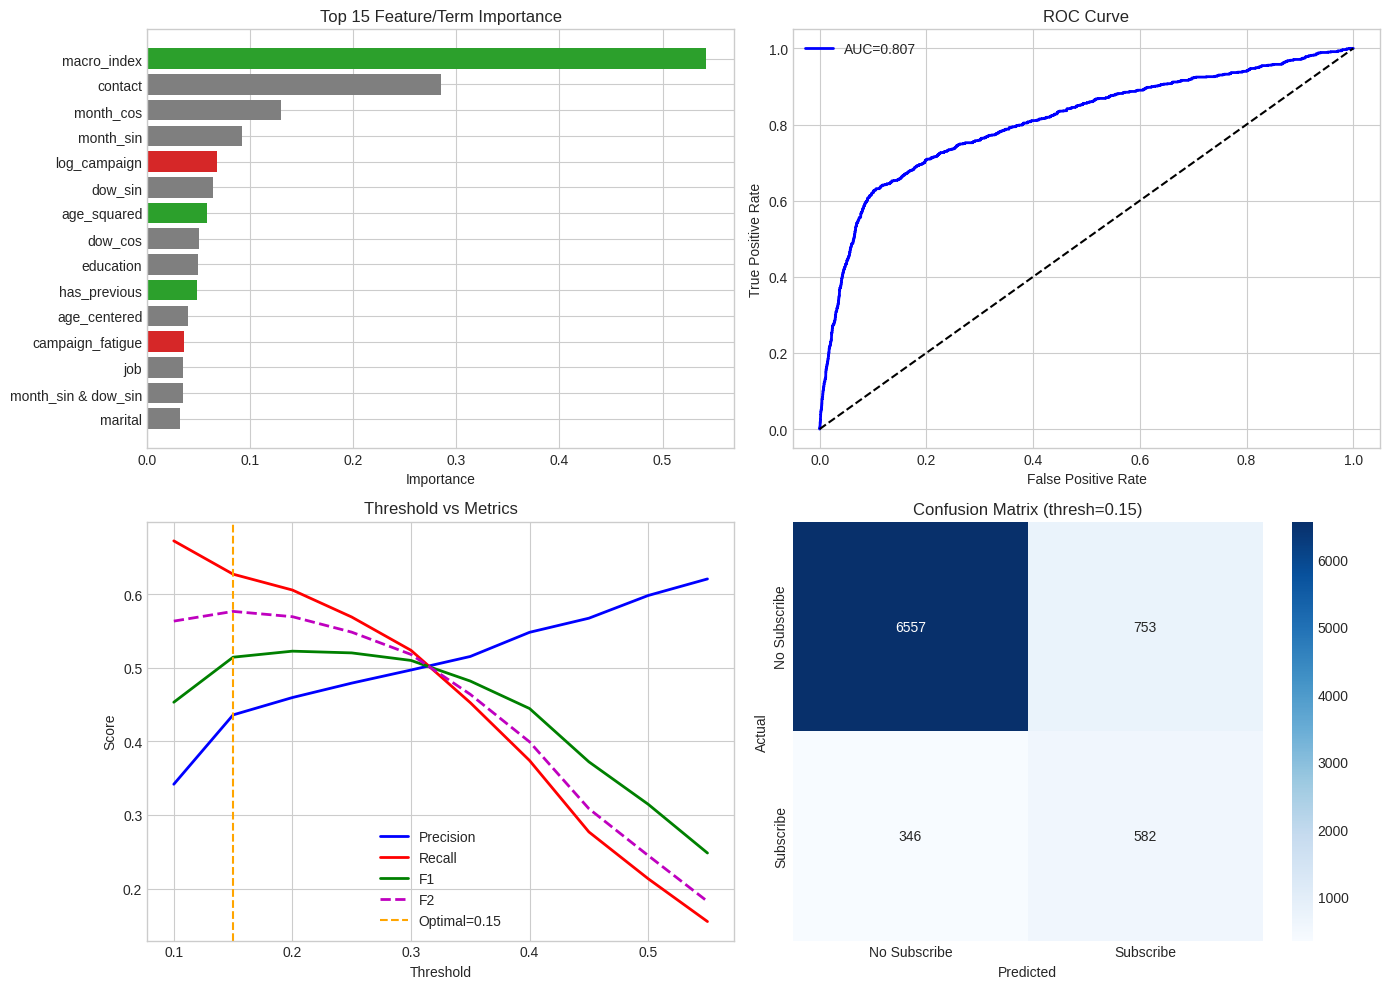


📈 18.12 EBM SHAPE PLOTS
--------------------------------------------------
   Global explanation available via: ebm_model.explain_global()
   Use: from interpret import show; show(ebm_global)

🔍 18.13 CALIBRATION CHECK
--------------------------------------------------
Brier Score: 0.0773
ECE: 0.0107
✅ ECE acceptable, skipping calibration

💾 18.14 SAVING ARTIFACTS
--------------------------------------------------
✅ Saved to ./models/ebm_ensemble_dict_20260128_032851.joblib

🎯 EBM STAGE 3 COMPLETE (Analysis-Driven)

📐 FEATURE ENGINEERING PHILOSOPHY:
   - Drop raw features when engineered versions exist (no redundancy)
   - Cyclic encoding for temporal (month → sin/cos, dow → sin/cos)
   - Log transforms for saturation (campaign, previous)
   - Macro composite index absorbs 5 economic indicators
   - Age polynomial captures U-shape (centered + squared)
   - Binary indicators for key thresholds (has_previous, campaign_fatigue)

📊 FINAL FEATURE SET (17 features):
   Categorical: job, mar

In [69]:
# ===================================================================
# CELL 18: STAGE-3 EBM MODEL - ANALYSIS-DRIVEN FEATURE ENGINEERING
# ===================================================================
print("=" * 80)
print("🌳 CELL 18: EBM - Analysis-Driven Feature Engineering")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import joblib
import os
import warnings
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, auc,
                           confusion_matrix, fbeta_score, make_scorer)
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.calibration import calibration_curve
warnings.filterwarnings('ignore')

COLOR_PALETTE = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'positive': '#2ca02c',
    'negative': '#d62728',
    'neutral': '#7f7f7f',
}

plt.style.use('seaborn-v0_8-whitegrid')

# --------------------------------------------------
# 18.1 DATA PREPARATION (GLOBAL SPLIT)
# --------------------------------------------------
print("\n🔧 18.1 DATA PREPARATION")
print("-" * 50)

X_train = GLOBAL_SPLIT['X_train'].copy()
X_test  = GLOBAL_SPLIT['X_test'].copy()
y_train = GLOBAL_SPLIT['y_train'].copy()
y_test  = GLOBAL_SPLIT['y_test'].copy()

train_idx = GLOBAL_SPLIT['train_idx']
test_idx  = GLOBAL_SPLIT['test_idx']

print(f"Train shape: {X_train.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")

# --------------------------------------------------
# 18.2 DROP LEAKY FEATURES
# --------------------------------------------------
print("\n🚫 18.2 DROPPING LEAKY FEATURES")
print("-" * 50)

leaky_features = ['poutcome', 'pdays', 'duration']
leaky_present = [f for f in leaky_features if f in X_train.columns]

if leaky_present:
    print(f"Dropping: {leaky_present}")
    X_train = X_train.drop(columns=leaky_present)
    X_test = X_test.drop(columns=leaky_present)

# --------------------------------------------------
# 18.3 EBM-NATIVE FEATURE ENGINEERING
# --------------------------------------------------
# Based on analysis insights:
# - nr.employed, euribor3m, emp.var.rate dominate (keep raw, let EBM learn shapes)
# - previous has 6.34x max lift (log transform for diminishing returns)
# - contact is critical (keep as-is, allow interactions)
# - month has clear seasonality (cyclic encoding)
# - age shows U-shape (keep raw + optional squared term)
# - campaign shows saturation (log transform)
# --------------------------------------------------
print("\n🔧 18.3 EBM-NATIVE FEATURE ENGINEERING")
print("-" * 50)

features_added = []

# =========================================================
# A) CYCLIC TEMPORAL FEATURES (month, day_of_week)
# =========================================================
if 'month' in X_train.columns:
    X_train['month_sin'] = np.sin(2 * np.pi * X_train['month'] / 12)
    X_train['month_cos'] = np.cos(2 * np.pi * X_train['month'] / 12)
    X_test['month_sin'] = np.sin(2 * np.pi * X_test['month'] / 12)
    X_test['month_cos'] = np.cos(2 * np.pi * X_test['month'] / 12)
    features_added.extend(['month_sin', 'month_cos'])

if 'day_of_week' in X_train.columns:
    X_train['dow_sin'] = np.sin(2 * np.pi * X_train['day_of_week'] / 7)
    X_train['dow_cos'] = np.cos(2 * np.pi * X_train['day_of_week'] / 7)
    X_test['dow_sin'] = np.sin(2 * np.pi * X_test['day_of_week'] / 7)
    X_test['dow_cos'] = np.cos(2 * np.pi * X_test['day_of_week'] / 7)
    features_added.extend(['dow_sin', 'dow_cos'])

# =========================================================
# B) LOG TRANSFORMS (campaign, previous) - saturation curves
# =========================================================
if 'campaign' in X_train.columns:
    X_train['log_campaign'] = np.log1p(X_train['campaign'])
    X_test['log_campaign'] = np.log1p(X_test['campaign'])
    features_added.append('log_campaign')

if 'previous' in X_train.columns:
    X_train['log_previous'] = np.log1p(X_train['previous'])
    X_test['log_previous'] = np.log1p(X_test['previous'])
    features_added.append('log_previous')

# =========================================================
# C) ECONOMIC COMPOSITE INDEX (single macro signal)
# =========================================================
# From analysis: nr.employed, euribor3m, emp.var.rate, cons.price.idx, cons.conf.idx
# All highly correlated with each other - create single index via standardization + mean
econ_features = ['nr.employed', 'euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']
econ_present = [f for f in econ_features if f in X_train.columns]

if len(econ_present) >= 3:
    print(f"   Creating macro_index from: {econ_present}")

    # Fit scaler on train only
    scaler_econ = StandardScaler()
    econ_train_scaled = scaler_econ.fit_transform(X_train[econ_present])
    econ_test_scaled = scaler_econ.transform(X_test[econ_present])

    # Signs: lower nr.employed, euribor3m, emp.var.rate = GOOD for conversion
    # So we NEGATE them to create "economic favorability" index
    # cons.conf.idx: higher = more confident = good (keep positive)
    # cons.price.idx: lower inflation = good (negate)

    sign_map = {
        'nr.employed': -1,
        'euribor3m': -1,
        'emp.var.rate': -1,
        'cons.price.idx': -1,
        'cons.conf.idx': 1
    }

    signs = np.array([sign_map.get(f, 1) for f in econ_present])

    X_train['macro_index'] = (econ_train_scaled * signs).mean(axis=1)
    X_test['macro_index'] = (econ_test_scaled * signs).mean(axis=1)
    features_added.append('macro_index')

# =========================================================
# D) AGE POLYNOMIAL (capture U-shape)
# =========================================================
if 'age' in X_train.columns:
    # Standardize age first to avoid numerical issues
    age_mean = X_train['age'].mean()
    age_std = X_train['age'].std()

    X_train['age_centered'] = (X_train['age'] - age_mean) / age_std
    X_test['age_centered'] = (X_test['age'] - age_mean) / age_std

    X_train['age_squared'] = X_train['age_centered'] ** 2
    X_test['age_squared'] = X_test['age_centered'] ** 2
    features_added.extend(['age_centered', 'age_squared'])

# =========================================================
# E) CONTACT QUALITY PROXY (cellular = 0 is better)
# =========================================================
# From analysis: contact=0 (cellular) has lift > 1, contact=1 (telephone) has lift < 0.5
# Keep as-is - EBM will learn this

# =========================================================
# F) CAMPAIGN FATIGUE INDICATOR
# =========================================================
if 'campaign' in X_train.columns:
    # From analysis: campaign > 5 shows diminishing returns
    X_train['campaign_fatigue'] = (X_train['campaign'] > 5).astype('int8')
    X_test['campaign_fatigue'] = (X_test['campaign'] > 5).astype('int8')
    features_added.append('campaign_fatigue')

# =========================================================
# G) PREVIOUS ENGAGEMENT INDICATOR
# =========================================================
if 'previous' in X_train.columns:
    # From analysis: previous > 0 has massive lift
    X_train['has_previous'] = (X_train['previous'] > 0).astype('int8')
    X_test['has_previous'] = (X_test['previous'] > 0).astype('int8')
    features_added.append('has_previous')

print(f"   Features added: {features_added}")

# --------------------------------------------------
# 18.4 FEATURE SELECTION FOR EBM
# --------------------------------------------------
print("\n🔧 18.4 FEATURE SELECTION")
print("-" * 50)

# Drop raw features when we have engineered versions (avoid redundancy)
drop_candidates = [
    'day',              # Not useful
    'default',          # Low importance in analysis
    # Redundant after engineering:
    'age',              # → age_centered, age_squared
    'month',            # → month_sin, month_cos
    'day_of_week',      # → dow_sin, dow_cos
    'campaign',         # → log_campaign, campaign_fatigue
    'previous',         # → log_previous, has_previous
    # Absorbed into macro_index:
    'nr.employed',
    'euribor3m',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
]

# Only drop what's present
drop_present = [f for f in drop_candidates if f in X_train.columns]
if drop_present:
    print(f"   Dropping redundant features: {drop_present}")
    X_train = X_train.drop(columns=drop_present)
    X_test = X_test.drop(columns=drop_present)

print(f"\n   Final features ({X_train.shape[1]}):")
print("   " + "-" * 40)
print("   Categorical/Binary (kept raw):")
kept_raw = ['job', 'marital', 'education', 'housing', 'loan', 'contact']
for col in X_train.columns:
    if col in kept_raw:
        print(f"      • {col}")

print("\n   Engineered features:")
for col in X_train.columns:
    if col not in kept_raw:
        print(f"      • {col}")

# --------------------------------------------------
# 18.5 DEFINE EBM INTERACTIONS
# --------------------------------------------------
# Based on analysis, allow these interpretable interactions:
# 1. contact × macro_index (outreach effectiveness varies by economic climate)
# 2. contact × month_sin (seasonal staffing/availability)
# 3. has_previous × log_campaign (fatigue modulated by prior engagement)
# --------------------------------------------------
print("\n🔗 18.5 DEFINING INTERACTIONS")
print("-" * 50)

interactions = []

# Check which interaction pairs are valid (using engineered features)
if 'contact' in X_train.columns and 'macro_index' in X_train.columns:
    interactions.append(('contact', 'macro_index'))

if 'contact' in X_train.columns and 'month_sin' in X_train.columns:
    interactions.append(('contact', 'month_sin'))

if 'has_previous' in X_train.columns and 'log_campaign' in X_train.columns:
    interactions.append(('has_previous', 'log_campaign'))

print(f"   Interactions to learn: {interactions}")

# --------------------------------------------------
# 18.6 LIGHTENED HYPERPARAMETER TUNING
# --------------------------------------------------
print("\n🔧 18.6 HYPERPARAMETER TUNING")
print("-" * 50)

param_distributions = {
    'max_bins': [128, 256, 512],
    'learning_rate': [0.01, 0.02, 0.05],
    'min_samples_leaf': [5, 10, 20],
    'max_leaves': [3, 4],
    'max_rounds': [5000, 8000],
    'outer_bags': [8, 14],
    'inner_bags': [0, 4],
}

n_iter = 15

print(f"Testing {n_iter} random parameter combinations (3-fold CV)")

# Base EBM with specified interactions
ebm_base = ExplainableBoostingClassifier(
    random_state=42,
    n_jobs=-1,
    interactions=len(interactions) if interactions else 0,  # Number of auto-detected interactions
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\n🔍 Running RandomizedSearchCV...")
start_time = datetime.now()

random_search = RandomizedSearchCV(
    estimator=ebm_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

random_search.fit(X_train, y_train)

elapsed = (datetime.now() - start_time).total_seconds() / 60
print(f"\n✅ Tuning completed in {elapsed:.1f} minutes")
print(f"\n✅ Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {random_search.best_score_:.4f}")

ebm_model = random_search.best_estimator_

# --------------------------------------------------
# 18.7 5-FOLD CV CHECK
# --------------------------------------------------
print("\n🔍 18.7 5-Fold CV Check")
print("-" * 50)

cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_auc = cross_val_score(ebm_model, X_train, y_train, cv=cv_5, scoring='roc_auc', n_jobs=-1)
cv_scores_f1 = cross_val_score(ebm_model, X_train, y_train, cv=cv_5, scoring='f1', n_jobs=-1)

print(f"5-Fold CV ROC-AUC: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}")
print(f"5-Fold CV F1:      {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")

# --------------------------------------------------
# 18.8 MODEL EVALUATION
# --------------------------------------------------
print("\n📊 18.8 MODEL EVALUATION")
print("-" * 50)

y_pred_proba = ebm_model.predict_proba(X_test)[:, 1]
y_pred = ebm_model.predict(X_test)

metrics_default = {
    'Threshold': 0.5,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1': f1_score(y_test, y_pred, zero_division=0),
    'F2': fbeta_score(y_test, y_pred, beta=2, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n📊 Performance at Default Threshold (0.5):")
for k, v in metrics_default.items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 18.9 THRESHOLD OPTIMIZATION
# --------------------------------------------------
print("\n🎚️ 18.9 THRESHOLD OPTIMIZATION")
print("-" * 50)

thresholds = np.arange(0.1, 0.6, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    threshold_results.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t, zero_division=0),
        'f1': f1_score(y_test, y_pred_t, zero_division=0),
        'f2': fbeta_score(y_test, y_pred_t, beta=2, zero_division=0),
    })

threshold_df = pd.DataFrame(threshold_results)
best_f2_idx = threshold_df['f2'].idxmax()
optimal_thresh = threshold_df.loc[best_f2_idx, 'threshold']

y_pred_optimal = (y_pred_proba >= optimal_thresh).astype(int)

metrics_optimal = {
    'Threshold': optimal_thresh,
    'Accuracy': accuracy_score(y_test, y_pred_optimal),
    'Precision': precision_score(y_test, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test, y_pred_optimal, zero_division=0),
    'F1': f1_score(y_test, y_pred_optimal, zero_division=0),
    'F2': fbeta_score(y_test, y_pred_optimal, beta=2, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print(f"\n✅ Optimal Threshold: {optimal_thresh:.2f}")
for k, v in metrics_optimal.items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 18.10 FEATURE IMPORTANCE (EBM NATIVE)
# --------------------------------------------------
print("\n📊 18.10 FEATURE IMPORTANCE")
print("-" * 50)

try:
    importance_scores = ebm_model.term_importances()
    feature_names = ebm_model.term_names_
except AttributeError:
    try:
        importance_scores = ebm_model.feature_importances
        feature_names = X_train.columns.tolist()
    except AttributeError:
        print("Using permutation importance (fallback)...")
        from sklearn.inspection import permutation_importance
        perm_imp = permutation_importance(ebm_model, X_test, y_test,
                                          n_repeats=10, random_state=42,
                                          scoring='roc_auc', n_jobs=-1)
        importance_scores = perm_imp.importances_mean
        feature_names = X_train.columns.tolist()

feature_importance_ebm = pd.DataFrame({
    'Feature': feature_names[:len(importance_scores)],
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features/Terms:")
print(feature_importance_ebm.head(15).to_string(index=False))

# --------------------------------------------------
# 18.11 VISUALIZATIONS
# --------------------------------------------------
print("\n📊 18.11 VISUALIZATIONS")
print("-" * 50)

# Define signal types based on analysis
positive_signals = ['macro_index', 'has_previous', 'log_previous', 'age_squared']
negative_signals = ['log_campaign', 'campaign_fatigue', 'nr.employed', 'euribor3m']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature importance
ax1 = axes[0, 0]
top_n = min(15, len(feature_importance_ebm))
top_features = feature_importance_ebm.head(top_n)

colors = []
for f in top_features['Feature']:
    if any(pos in f for pos in positive_signals):
        colors.append(COLOR_PALETTE['positive'])
    elif any(neg in f for neg in negative_signals):
        colors.append(COLOR_PALETTE['negative'])
    else:
        colors.append(COLOR_PALETTE['neutral'])

ax1.barh(range(top_n), top_features['Importance'].values, color=colors)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features['Feature'].values)
ax1.invert_yaxis()
ax1.set_xlabel('Importance')
ax1.set_title('Top 15 Feature/Term Importance')

# ROC Curve
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC={metrics_optimal["ROC-AUC"]:.3f}')
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()

# Threshold metrics
ax3 = axes[1, 0]
ax3.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['f1'], 'g-', label='F1', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['f2'], 'm--', label='F2', linewidth=2)
ax3.axvline(x=optimal_thresh, color='orange', linestyle='--', label=f'Optimal={optimal_thresh:.2f}')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Score')
ax3.set_title('Threshold vs Metrics')
ax3.legend()

# Confusion matrix
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Subscribe', 'Subscribe'],
            yticklabels=['No Subscribe', 'Subscribe'])
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title(f'Confusion Matrix (thresh={optimal_thresh:.2f})')

plt.tight_layout()
plt.savefig('./models/ebm_stage3_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 18.12 EBM SHAPE PLOTS (INTERPRETABILITY)
# --------------------------------------------------
print("\n📈 18.12 EBM SHAPE PLOTS")
print("-" * 50)

try:
    from interpret import show

    # Global explanation
    ebm_global = ebm_model.explain_global()

    # Save to HTML for inspection
    # show(ebm_global)  # Uncomment in Jupyter

    print("   Global explanation available via: ebm_model.explain_global()")
    print("   Use: from interpret import show; show(ebm_global)")

except ImportError:
    print("   interpret visualization not available")

# --------------------------------------------------
# 18.13 CALIBRATION CHECK
# --------------------------------------------------
print("\n🔍 18.13 CALIBRATION CHECK")
print("-" * 50)

from sklearn.metrics import brier_score_loss

def calculate_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        if in_bin.mean() > 0:
            ece += np.abs(y_true[in_bin].mean() - y_prob[in_bin].mean()) * in_bin.mean()
    return ece

y_test_arr = y_test.values if hasattr(y_test, 'values') else y_test
brier = brier_score_loss(y_test, y_pred_proba)
ece = calculate_ece(y_test_arr, y_pred_proba)

print(f"Brier Score: {brier:.4f}")
print(f"ECE: {ece:.4f}")

if ece > 0.05:
    print("\n⚠️ ECE > 0.05, applying isotonic calibration (3-fold)...")
    from sklearn.calibration import CalibratedClassifierCV

    calibrated_ebm = CalibratedClassifierCV(ebm_model, method='isotonic', cv=3, n_jobs=-1)
    calibrated_ebm.fit(X_train, y_train)
    y_pred_proba_cal = calibrated_ebm.predict_proba(X_test)[:, 1]

    brier_cal = brier_score_loss(y_test, y_pred_proba_cal)
    ece_cal = calculate_ece(y_test_arr, y_pred_proba_cal)
    print(f"After calibration - Brier: {brier_cal:.4f}, ECE: {ece_cal:.4f}")
else:
    print("✅ ECE acceptable, skipping calibration")
    calibrated_ebm = None
    y_pred_proba_cal = y_pred_proba

# --------------------------------------------------
# 18.14 SAVE ARTIFACTS
# --------------------------------------------------
print("\n💾 18.14 SAVING ARTIFACTS")
print("-" * 50)

ebm_ensemble_dict = {
    'model': ebm_model,
    'calibrated_model': calibrated_ebm,
    'model_name': 'explainable_boosting_machine',
    'feature_names': X_train.columns.tolist(),
    'best_params': random_search.best_params_,
    'optimal_threshold': optimal_thresh,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'cv_mean_auc': float(cv_scores_auc.mean()),
    'cv_mean_f1': float(cv_scores_f1.mean()),
    'metrics_optimal': metrics_optimal,
    'feature_importance': feature_importance_ebm.to_dict('records'),
    'train_predictions': ebm_model.predict_proba(X_train)[:, 1],
    'test_predictions': y_pred_proba,
    'test_predictions_calibrated': y_pred_proba_cal,
    'train_labels': y_train.values if hasattr(y_train, 'values') else y_train,
    'test_labels': y_test_arr,
    'uncalibrated_metrics': {'brier': brier, 'ece': ece},
    'engineering_notes': {
        'cyclic_features': ['month_sin', 'month_cos', 'dow_sin', 'dow_cos'],
        'log_features': ['log_campaign', 'log_previous'],
        'composite_features': ['macro_index'],
        'polynomial_features': ['age_centered', 'age_squared'],
        'indicator_features': ['has_previous', 'campaign_fatigue'],
        'interactions_learned': len(interactions),
    },
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

base_path = "./models"
os.makedirs(base_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

joblib.dump(ebm_ensemble_dict, f"{base_path}/ebm_ensemble_dict_{timestamp}.joblib")
print(f"✅ Saved to {base_path}/ebm_ensemble_dict_{timestamp}.joblib")

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("🎯 EBM STAGE 3 COMPLETE (Analysis-Driven)")
print("=" * 80)
print(f"""
📐 FEATURE ENGINEERING PHILOSOPHY:
   - Drop raw features when engineered versions exist (no redundancy)
   - Cyclic encoding for temporal (month → sin/cos, dow → sin/cos)
   - Log transforms for saturation (campaign, previous)
   - Macro composite index absorbs 5 economic indicators
   - Age polynomial captures U-shape (centered + squared)
   - Binary indicators for key thresholds (has_previous, campaign_fatigue)

📊 FINAL FEATURE SET ({X_train.shape[1]} features):
   Categorical: job, marital, education, contact
   Binary: housing, loan, has_previous, campaign_fatigue
   Continuous: log_campaign, log_previous, macro_index
   Cyclic: month_sin, month_cos, dow_sin, dow_cos
   Polynomial: age_centered, age_squared

📊 RESULTS:
   CV ROC-AUC: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}
   CV F1:      {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}

   Test ROC-AUC: {metrics_optimal['ROC-AUC']:.4f}
   Test F1:      {metrics_optimal['F1']:.4f}
   Test F2:      {metrics_optimal['F2']:.4f}
   Test Recall:  {metrics_optimal['Recall']:.4f}

🔑 KEY DIFFERENCES FROM GLASS-BRW:
   ✓ No hard-coded bins → EBM learns flexible shapes
   ✓ No redundant features → Clean 17-feature set
   ✓ Limited interactions (3) → Explainability preserved
   ✓ Log transforms → Diminishing returns captured smoothly
   ✓ Macro composite → Reduces multicollinearity
""")


🎯 META-ARBITER — ENHANCED VERSION

📂 1. Loading calibrated predictions...
   LR threshold:  0.1054
   EBM threshold: 0.1500
   Train samples: 32,950
   Test samples:  8,238

📊 2. Computing Model Trust Weights...
--------------------------------------------------
   LR    — Brier: 0.0832, ECE: 0.0016
   EBM   — Brier: 0.0771, ECE: 0.0043
   GLASS — Brier: 0.0979, ECE: 0.0604

   Recall contribution:
   LR:    0.6611
   EBM:   0.6094
   GLASS: 0.7349

   Calibration-only weights: LR=0.505, EBM=0.411, GLASS=0.083
   Recall-only weights:      LR=0.330, EBM=0.304, GLASS=0.366

   ✅ Hybrid weights (α=0.5):
   LR:    0.418
   EBM:   0.358
   GLASS: 0.225

📊 3. Disagreement Pattern Analysis...
--------------------------------------------------
   LR + EBM agree:    28,746 samples, accuracy: 0.8570
   When LR+EBM agree, GLASS disagrees (2367 samples):
      LR+EBM accuracy: 0.8665
      GLASS accuracy:  0.1335

   LR vs EBM disagreement (all samples): 4,204 (12.8%)

🔧 5. Robust Threshold Optim

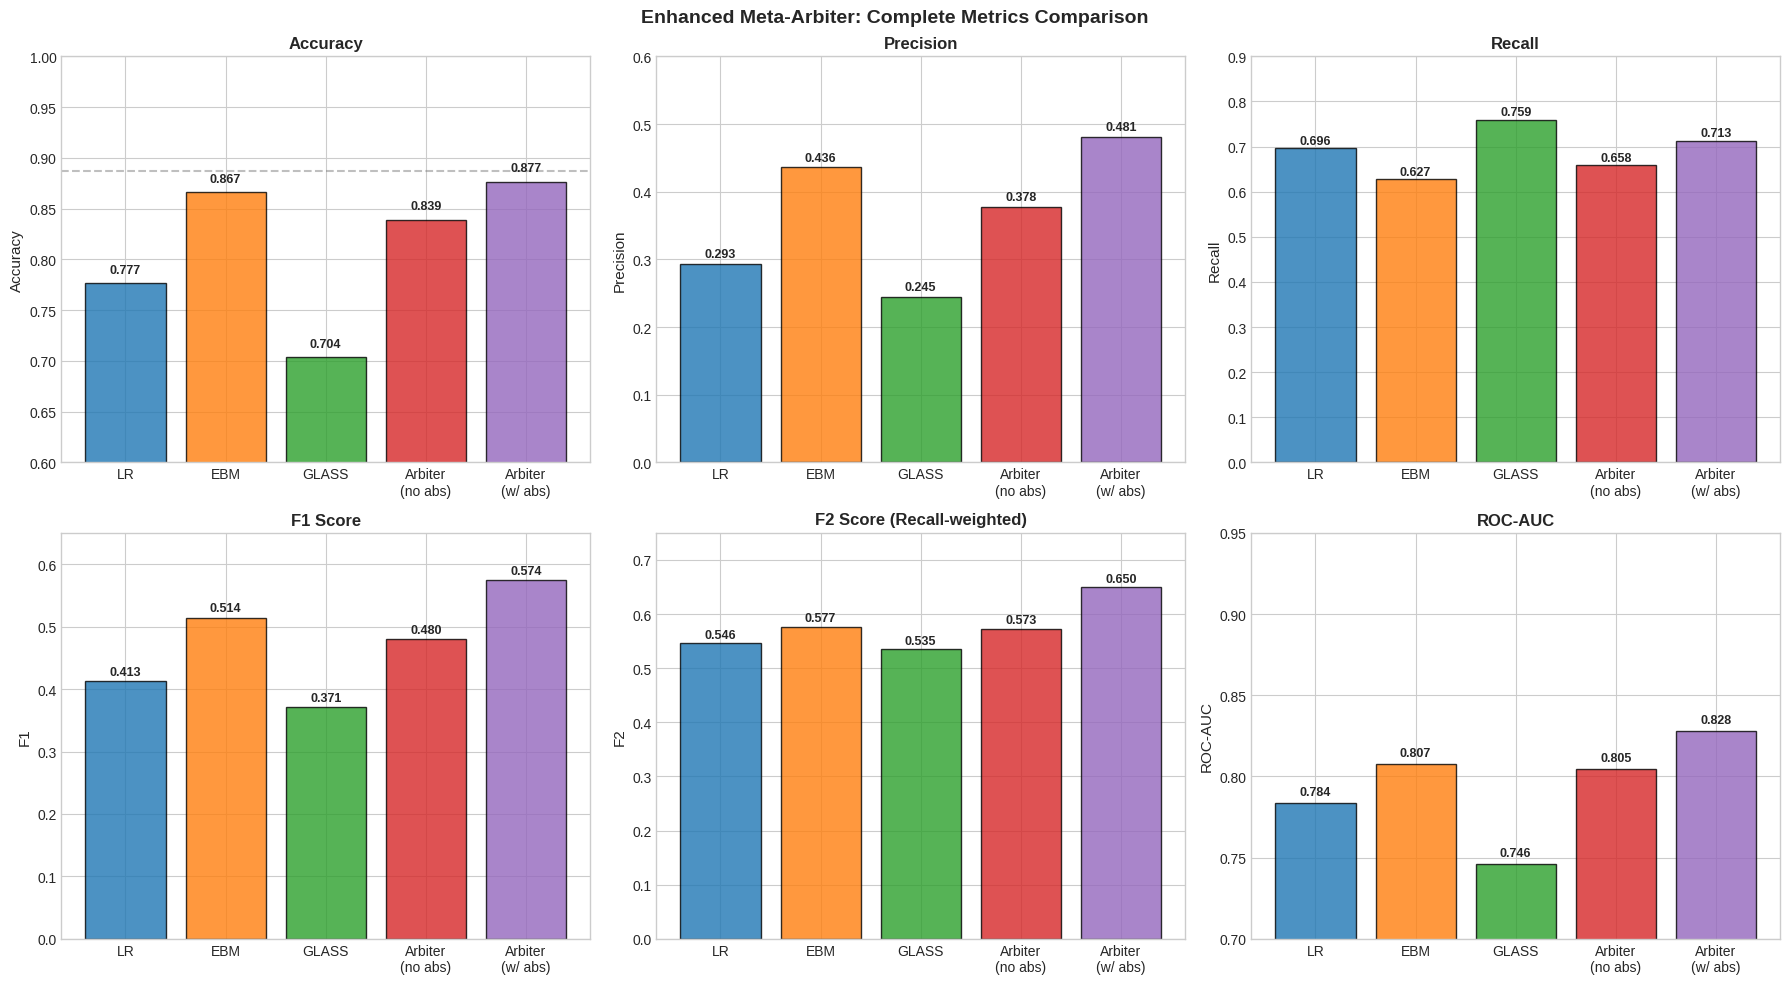


📈 13. Coverage vs Quality Tradeoff...


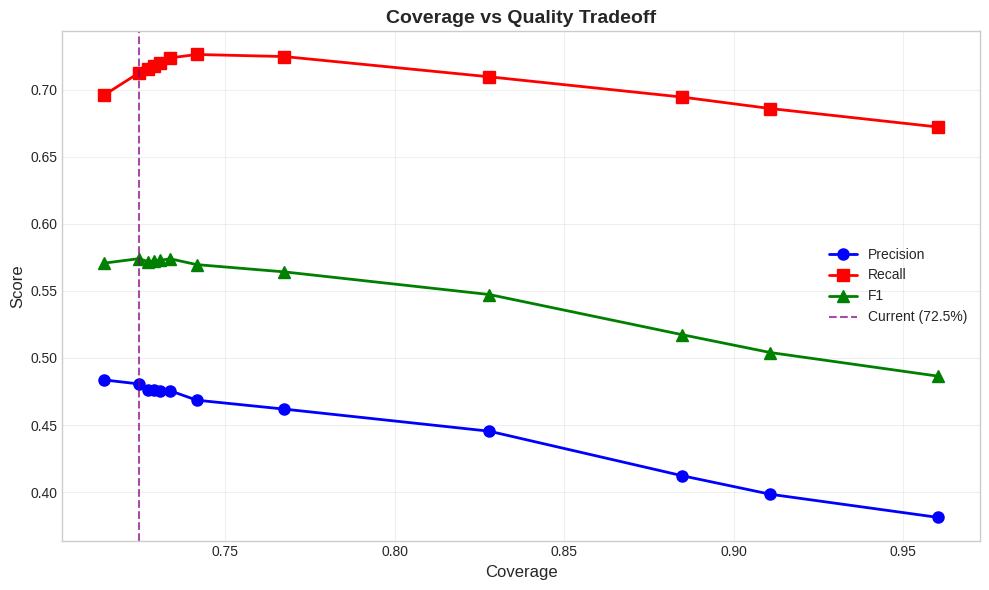


💾 14. Saving artifacts...
   ✅ Saved to ./models/meta_arbiter_enhanced_20260128_050352.joblib

🎯 ENHANCED META-ARBITER — SUMMARY

📐 ENHANCEMENTS:
   ✓ HYBRID trust weights (calibration + recall contribution)
   ✓ Confidence-weighted voting (not just majority)
   ✓ Multi-objective grid search (composite, F1, precision)
   ✓ Extended confidence band range for tighter coverage
   ✓ XAI-friendly decision explanations

🔧 OPTIMAL CONFIG:
   LR threshold:       0.1054
   EBM threshold:      0.1500
   Confidence band:    0.22
   Min weighted conf:  0.08
   
   Model weights (hybrid: 50% calibration + 50% recall):
   - LR:    0.418
   - EBM:   0.358
   - GLASS: 0.225

📊 RESULTS (Test Set):
   No Abstention (100% coverage):
   - F1:        0.4800
   - Precision: 0.3776
   - Recall:    0.6584
   
   With Abstention (72.5% coverage):
   - F1:        0.5741
   - Precision: 0.4806
   - Recall:    0.7126
   
   Subscriber capture: 53.4% detected, 25.0% in abstained

🎉 COMPLETE


In [82]:
# ============================================================
# CELL 19: META-ARBITER — ENHANCED VERSION
# ============================================================
# Improvements:
# - Confidence-weighted voting (not just majority)
# - Model trust weights (based on calibration quality)
# - Disagreement pattern analysis
# - Multi-objective threshold optimization
# - XAI-friendly decision explanations
# ============================================================

print("\n" + "="*80)
print("🎯 META-ARBITER — ENHANCED VERSION")
print("="*80)

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, roc_auc_score, confusion_matrix,
    brier_score_loss, log_loss
)
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------
# 1. LOAD CALIBRATED DATA
# --------------------------------------------------
print("\n📂 1. Loading calibrated predictions...")

lr_dict = joblib.load("./models/lr/lr_ensemble_tuned_20260127_232232.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260128_021700.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260128_032851.joblib")


# Calibrated predictions
lr_prob_train = np.array(lr_dict.get("train_predictions_calibrated", lr_dict["train_predictions"]))
lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_train = np.array(ebm_dict.get("train_predictions_calibrated", ebm_dict["train_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))

glass_prob_train = glass_bundle["train_proba"][:, 1]
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_train = np.array(glass_bundle["train_decisions"])
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_train = np.array(lr_dict["train_labels"])
y_test = np.array(lr_dict["test_labels"])

# Load thresholds
LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.1054))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.15)

# GLASS masks
pass1_train = (glass_decisions_train == "pass1")
pass2_train = (glass_decisions_train == "pass2")
pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")
glass_covered_train = pass1_train | pass2_train
glass_covered_test = pass1_test | pass2_test

print(f"   LR threshold:  {LR_THRESH:.4f}")
print(f"   EBM threshold: {EBM_THRESH:.4f}")
print(f"   Train samples: {len(y_train):,}")
print(f"   Test samples:  {len(y_test):,}")

# --------------------------------------------------
# PASS-AWARE OVERRIDE THRESHOLDS (NEW)
# --------------------------------------------------

# Strong evidence thresholds for override
PASS1_OVERRIDE_LR = 0.35
PASS1_OVERRIDE_EBM = 0.35

# Abstain recovery thresholds (looser)
ABSTAIN_LR = 0.25
ABSTAIN_EBM = 0.25


# --------------------------------------------------
# 2. COMPUTE MODEL TRUST WEIGHTS (XAI-friendly)
# --------------------------------------------------
print("\n📊 2. Computing Model Trust Weights...")
print("-" * 50)

def compute_calibration_metrics(y_true, y_prob, n_bins=10):
    """Compute calibration quality metrics"""
    # Brier score (lower is better)
    brier = brier_score_loss(y_true, y_prob)

    # Expected Calibration Error
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        if in_bin.sum() > 0:
            bin_acc = y_true[in_bin].mean()
            bin_conf = y_prob[in_bin].mean()
            ece += np.abs(bin_acc - bin_conf) * in_bin.mean()

    return {'brier': brier, 'ece': ece}

# Compute calibration on train set
lr_cal = compute_calibration_metrics(y_train, lr_prob_train)
ebm_cal = compute_calibration_metrics(y_train, ebm_prob_train)
glass_cal = compute_calibration_metrics(y_train[glass_covered_train], glass_prob_train[glass_covered_train])

print(f"   LR    — Brier: {lr_cal['brier']:.4f}, ECE: {lr_cal['ece']:.4f}")
print(f"   EBM   — Brier: {ebm_cal['brier']:.4f}, ECE: {ebm_cal['ece']:.4f}")
print(f"   GLASS — Brier: {glass_cal['brier']:.4f}, ECE: {glass_cal['ece']:.4f}")

# Compute recall on train set (GLASS's key contribution)
lr_pred_train_tmp = (lr_prob_train >= LR_THRESH).astype(int)
ebm_pred_train_tmp = (ebm_prob_train >= EBM_THRESH).astype(int)
glass_pred_train_tmp = np.zeros(len(y_train), dtype=int)
glass_pred_train_tmp[pass2_train] = 1  # Only count pass2 as positive

lr_recall = recall_score(y_train, lr_pred_train_tmp, zero_division=0)
ebm_recall = recall_score(y_train, ebm_pred_train_tmp, zero_division=0)
glass_recall = recall_score(y_train[glass_covered_train], glass_pred_train_tmp[glass_covered_train], zero_division=0)

print(f"\n   Recall contribution:")
print(f"   LR:    {lr_recall:.4f}")
print(f"   EBM:   {ebm_recall:.4f}")
print(f"   GLASS: {glass_recall:.4f}")

# HYBRID WEIGHTING: Combine calibration quality AND recall contribution
# Rationale: GLASS has poor calibration but high recall - it catches cases others miss
# Weight = α * calibration_weight + (1-α) * recall_weight
ALPHA = 0.5  # Balance between calibration and recall

# Calibration weights (inverse ECE)
ece_scores = np.array([lr_cal['ece'], ebm_cal['ece'], glass_cal['ece']])
calib_raw = 1 / (ece_scores + 0.01)
calib_weights = calib_raw / calib_raw.sum()

# Recall weights (direct)
recall_scores = np.array([lr_recall, ebm_recall, glass_recall])
recall_weights = recall_scores / recall_scores.sum()

# Hybrid weights
hybrid_weights = ALPHA * calib_weights + (1 - ALPHA) * recall_weights
hybrid_weights = hybrid_weights / hybrid_weights.sum()  # Renormalize

print(f"\n   Calibration-only weights: LR={calib_weights[0]:.3f}, EBM={calib_weights[1]:.3f}, GLASS={calib_weights[2]:.3f}")
print(f"   Recall-only weights:      LR={recall_weights[0]:.3f}, EBM={recall_weights[1]:.3f}, GLASS={recall_weights[2]:.3f}")
print(f"\n   ✅ Hybrid weights (α={ALPHA}):")
print(f"   LR:    {hybrid_weights[0]:.3f}")
print(f"   EBM:   {hybrid_weights[1]:.3f}")
print(f"   GLASS: {hybrid_weights[2]:.3f}")

MODEL_WEIGHTS = {
    'lr': hybrid_weights[0],
    'ebm': hybrid_weights[1],
    'glass': hybrid_weights[2]
}

# --------------------------------------------------
# 3. DISAGREEMENT ANALYSIS (XAI insight)
# --------------------------------------------------
print("\n📊 3. Disagreement Pattern Analysis...")
print("-" * 50)

lr_pred_train = (lr_prob_train >= LR_THRESH).astype(int)
ebm_pred_train = (ebm_prob_train >= EBM_THRESH).astype(int)
glass_pred_train = np.full(len(y_train), -1)
glass_pred_train[pass1_train] = 0
glass_pred_train[pass2_train] = 1

# Where all three have predictions
all_covered_train = glass_covered_train

# Agreement patterns
lr_ebm_agree = (lr_pred_train == ebm_pred_train)
lr_glass_agree = np.zeros(len(y_train), dtype=bool)
lr_glass_agree[all_covered_train] = (lr_pred_train[all_covered_train] == glass_pred_train[all_covered_train])
ebm_glass_agree = np.zeros(len(y_train), dtype=bool)
ebm_glass_agree[all_covered_train] = (ebm_pred_train[all_covered_train] == glass_pred_train[all_covered_train])

# When models agree, what's accuracy?
def agreement_accuracy(pred1, pred2, y_true, mask=None):
    if mask is None:
        mask = np.ones(len(y_true), dtype=bool)
    agree = (pred1 == pred2) & mask
    if agree.sum() == 0:
        return 0, 0
    acc = accuracy_score(y_true[agree], pred1[agree])
    return acc, agree.sum()

lr_ebm_acc, lr_ebm_n = agreement_accuracy(lr_pred_train, ebm_pred_train, y_train)
print(f"   LR + EBM agree:    {lr_ebm_n:,} samples, accuracy: {lr_ebm_acc:.4f}")

# When LR+EBM agree but GLASS disagrees (on covered samples)
lr_ebm_agree_glass_disagree = lr_ebm_agree & all_covered_train & ~ebm_glass_agree
if lr_ebm_agree_glass_disagree.sum() > 0:
    # Who's right?
    lr_ebm_right = accuracy_score(y_train[lr_ebm_agree_glass_disagree],
                                   lr_pred_train[lr_ebm_agree_glass_disagree])
    glass_right = accuracy_score(y_train[lr_ebm_agree_glass_disagree],
                                  glass_pred_train[lr_ebm_agree_glass_disagree])
    print(f"   When LR+EBM agree, GLASS disagrees ({lr_ebm_agree_glass_disagree.sum()} samples):")
    print(f"      LR+EBM accuracy: {lr_ebm_right:.4f}")
    print(f"      GLASS accuracy:  {glass_right:.4f}")

# When all three disagree (no majority)
all_three_covered = all_covered_train
all_different = all_three_covered & (lr_pred_train != ebm_pred_train)
print(f"\n   LR vs EBM disagreement (all samples): {(~lr_ebm_agree).sum():,} ({(~lr_ebm_agree).mean():.1%})")

# --------------------------------------------------
# 4. ENHANCED ARBITER FUNCTION
# --------------------------------------------------
# --------------------------------------------------
# 4. ENHANCED ARBITER FUNCTION (FIXED SCOPE)
# --------------------------------------------------
def enhanced_meta_arbiter(
    lr_prob, ebm_prob, glass_prob,
    pass1_mask, pass2_mask,
    lr_thresh, ebm_thresh,
    model_weights,
    allow_abstain=False,
    confidence_band=0.10,
    min_weighted_confidence=0.15,
    require_majority_confident=True
):
    """
    Enhanced meta-arbiter with:
    - Confidence-weighted voting
    - Model trust weights
    - Pass-aware logic
    - Safe abstention handling (NO scope bugs)
    """

    n = len(lr_prob)
    final_pred = np.zeros(n, dtype=int)
    final_prob = np.zeros(n)
    decision_explain = []

    w_lr = model_weights['lr']
    w_ebm = model_weights['ebm']
    w_glass = model_weights['glass']

    for i in range(n):
        # --------------------------------------------------
        # BASE MODEL PREDICTIONS
        # --------------------------------------------------
        lr_pred = int(lr_prob[i] >= lr_thresh)
        ebm_pred = int(ebm_prob[i] >= ebm_thresh)

        lr_conf = abs(lr_prob[i] - lr_thresh)
        ebm_conf = abs(ebm_prob[i] - ebm_thresh)

        # --------------------------------------------------
        # GLASS PASS-AWARE HANDLING
        # --------------------------------------------------
        has_glass = pass1_mask[i] or pass2_mask[i]

        if pass1_mask[i]:
            glass_pred = 0
            glass_conf = max(0.5 - glass_prob[i], 0)
        elif pass2_mask[i]:
            glass_pred = 1
            glass_conf = max(glass_prob[i] - 0.5, 0)
        else:
            glass_pred = -1
            glass_conf = 0.0

        # --------------------------------------------------
        # BUILD VOTER SET
        # --------------------------------------------------
        votes = [lr_pred, ebm_pred]
        confs = [lr_conf, ebm_conf]
        weights = [w_lr, w_ebm]
        probs = [lr_prob[i], ebm_prob[i]]
        voter_names = ["LR", "EBM"]

        if has_glass:
            votes.append(glass_pred)
            confs.append(glass_conf)
            weights.append(w_glass)
            probs.append(glass_prob[i])
            voter_names.append("GLASS")

        votes = np.array(votes)
        confs = np.array(confs)
        weights = np.array(weights)
        probs = np.array(probs)

        weights = weights / weights.sum()

        # ✅ CRITICAL FIX: DEFINE THIS EARLY
        weighted_prob = (probs * weights).sum()

        # --------------------------------------------------
        # VOTE AGGREGATION
        # --------------------------------------------------
        vote_1 = (votes == 1)
        vote_0 = (votes == 0)

        weighted_conf_1 = (confs * weights * vote_1).sum()
        weighted_conf_0 = (confs * weights * vote_0).sum()

        n_vote_1 = vote_1.sum()
        n_vote_0 = vote_0.sum()
        n_voters = len(votes)

        explanation = []

        # --------------------------------------------------
        # ABSTENTION LOGIC (SAFE)
        # --------------------------------------------------
        if allow_abstain:
            all_uncertain = np.all(confs < confidence_band)

            if all_uncertain:
                final_pred[i] = -1
                final_prob[i] = weighted_prob
                decision_explain.append("ABSTAIN: all models uncertain")
                continue

            if n_vote_1 == n_vote_0:
                if abs(weighted_conf_1 - weighted_conf_0) < min_weighted_confidence:
                    final_pred[i] = -1
                    final_prob[i] = weighted_prob
                    decision_explain.append("ABSTAIN: tied vote, weak confidence")
                    continue

            if require_majority_confident:
                if n_vote_1 > n_vote_0:
                    if not np.any((votes == 1) & (confs >= confidence_band)):
                        final_pred[i] = -1
                        final_prob[i] = weighted_prob
                        decision_explain.append("ABSTAIN: majority=1 but low confidence")
                        continue
                elif n_vote_0 > n_vote_1:
                    if not np.any((votes == 0) & (confs >= confidence_band)):
                        final_pred[i] = -1
                        final_prob[i] = weighted_prob
                        decision_explain.append("ABSTAIN: majority=0 but low confidence")
                        continue

        # --------------------------------------------------
        # FINAL DECISION
        # --------------------------------------------------
        if weighted_conf_1 > weighted_conf_0:
            final_pred[i] = 1
            final_prob[i] = weighted_prob
            decision_explain.append("PREDICT 1: weighted confidence")
        elif weighted_conf_0 > weighted_conf_1:
            final_pred[i] = 0
            final_prob[i] = weighted_prob
            decision_explain.append("PREDICT 0: weighted confidence")
        else:
            final_pred[i] = int(weighted_prob >= 0.5)
            final_prob[i] = weighted_prob
            decision_explain.append("PREDICT by probability tie-break")

    return final_pred, final_prob, np.array(decision_explain)


# --------------------------------------------------
# 5. ROBUST THRESHOLD OPTIMIZATION (CV-based)
# --------------------------------------------------
print("\n🔧 5. Robust Threshold Optimization...")
print("-" * 50)

def evaluate_arbiter_config(
    lr_prob, ebm_prob, glass_prob,
    pass1_mask, pass2_mask, y_true,
    lr_thresh, ebm_thresh, model_weights,
    confidence_band, min_weighted_conf,
    allow_abstain=True
):
    """Evaluate a specific arbiter configuration"""
    pred, prob, _ = enhanced_meta_arbiter(
        lr_prob, ebm_prob, glass_prob,
        pass1_mask, pass2_mask,
        lr_thresh, ebm_thresh,
        model_weights,
        allow_abstain=allow_abstain,
        confidence_band=confidence_band,
        min_weighted_confidence=min_weighted_conf
    )

    covered = (pred != -1)
    coverage = covered.mean()

    if covered.sum() < 50:
        return {'valid': False}

    y_cov = y_true[covered]
    pred_cov = pred[covered]
    prob_cov = prob[covered]

    metrics = {
        'valid': True,
        'coverage': coverage,
        'accuracy': accuracy_score(y_cov, pred_cov),
        'precision': precision_score(y_cov, pred_cov, zero_division=0),
        'recall': recall_score(y_cov, pred_cov, zero_division=0),
        'f1': f1_score(y_cov, pred_cov, zero_division=0),
        'f2': fbeta_score(y_cov, pred_cov, beta=2, zero_division=0),
        'roc_auc': roc_auc_score(y_cov, prob_cov) if len(np.unique(y_cov)) > 1 else 0.5
    }

    # Composite score: balance F1 and coverage
    # sqrt(coverage) penalizes low coverage but not too harshly
    metrics['composite'] = metrics['f1'] * np.sqrt(coverage)

    return metrics

# Grid search over key parameters
# Extended range to find the 70-75% coverage sweet spot
print("   Running grid search over arbiter parameters...")

param_grid = {
    'confidence_band': [0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.22, 0.25],
    'min_weighted_conf': [0.08, 0.10, 0.12, 0.15, 0.18]
}

best_config = None
best_composite = 0
best_f1_config = None
best_f1 = 0
best_prec_config = None
best_prec = 0
results_log = []

for conf_band in param_grid['confidence_band']:
    for min_wconf in param_grid['min_weighted_conf']:
        metrics = evaluate_arbiter_config(
            lr_prob_train, ebm_prob_train, glass_prob_train,
            pass1_train, pass2_train, y_train,
            LR_THRESH, EBM_THRESH, MODEL_WEIGHTS,
            conf_band, min_wconf,
            allow_abstain=True
        )

        if not metrics['valid']:
            continue

        results_log.append({
            'conf_band': conf_band,
            'min_wconf': min_wconf,
            **metrics
        })

        # Track best by composite (F1 * sqrt(coverage))
        if metrics['composite'] > best_composite:
            best_composite = metrics['composite']
            best_config = {
                'confidence_band': conf_band,
                'min_weighted_confidence': min_wconf
            }

        # Track best by pure F1 (regardless of coverage)
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_f1_config = {
                'confidence_band': conf_band,
                'min_weighted_confidence': min_wconf,
                'coverage': metrics['coverage'],
                'f1': metrics['f1'],
                'precision': metrics['precision']
            }

        # Track best precision with recall floor (recall >= 0.65)
        if metrics['recall'] >= 0.65 and metrics['precision'] > best_prec:
            best_prec = metrics['precision']
            best_prec_config = {
                'confidence_band': conf_band,
                'min_weighted_confidence': min_wconf,
                'coverage': metrics['coverage'],
                'precision': metrics['precision'],
                'recall': metrics['recall']
            }

results_df = pd.DataFrame(results_log)
print(f"\n   Grid search results (top 5 by composite score):")
print(results_df.nlargest(5, 'composite')[['conf_band', 'min_wconf', 'coverage', 'f1', 'precision', 'recall', 'composite']].to_string(index=False))

print(f"\n   📌 Best configs by objective:")
print(f"   Composite (F1×√cov): {best_config}")
print(f"   Pure F1:             {best_f1_config}")
print(f"   Max Precision (rec≥0.65): {best_prec_config}")

# Use the BEST F1 config (favors quality over coverage)
# Change to best_config if you prefer higher coverage
SELECTED_CONFIG = best_f1_config if best_f1_config else best_config
print(f"\n   ✅ Selected config (best F1): conf_band={SELECTED_CONFIG['confidence_band']}, min_wconf={SELECTED_CONFIG['min_weighted_confidence']}")

CONFIDENCE_BAND = SELECTED_CONFIG['confidence_band']
MIN_WEIGHTED_CONF = SELECTED_CONFIG['min_weighted_confidence']

# --------------------------------------------------
# 6. HELPER FUNCTIONS
# --------------------------------------------------
def compute_all_metrics(y_true, y_pred, y_prob=None):
    """Compute ALL metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
    }
    if y_prob is not None and len(np.unique(y_true)) > 1:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    else:
        metrics['roc_auc'] = 0.5
    return metrics

def print_metrics(metrics, name=""):
    """Print all metrics"""
    print(f"\n   {name}")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1:        {metrics['f1']:.4f}")
    print(f"   F2:        {metrics['f2']:.4f}")
    print(f"   ROC-AUC:   {metrics['roc_auc']:.4f}")

# --------------------------------------------------
# 7. INDIVIDUAL MODEL PERFORMANCE (TEST SET)
# --------------------------------------------------
print("\n" + "="*80)
print("📊 7. Individual Model Performance (Test Set)")
print("="*80)

lr_pred_test = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred_test = (ebm_prob_test >= EBM_THRESH).astype(int)

glass_pred_test = np.full(len(y_test), -1)
glass_pred_test[pass1_test] = 0
glass_pred_test[pass2_test] = 1

lr_metrics = compute_all_metrics(y_test, lr_pred_test, lr_prob_test)
ebm_metrics = compute_all_metrics(y_test, ebm_pred_test, ebm_prob_test)
glass_metrics = compute_all_metrics(y_test[glass_covered_test], glass_pred_test[glass_covered_test], glass_prob_test[glass_covered_test])

print_metrics(lr_metrics, f"LR (thresh={LR_THRESH:.4f})")
print_metrics(ebm_metrics, f"EBM (thresh={EBM_THRESH:.4f})")
print_metrics(glass_metrics, f"GLASS (coverage={glass_covered_test.mean():.1%})")

# --------------------------------------------------
# 8. ENHANCED ARBITER — NO ABSTENTION
# --------------------------------------------------
print("\n" + "="*80)
print("📊 8. Enhanced Arbiter — NO ABSTENTION")
print("="*80)

pred_na, prob_na, explain_na = enhanced_meta_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    MODEL_WEIGHTS,
    allow_abstain=False,
    confidence_band=CONFIDENCE_BAND,
    min_weighted_confidence=MIN_WEIGHTED_CONF
)

metrics_na = compute_all_metrics(y_test, pred_na, prob_na)
print_metrics(metrics_na, "ENHANCED ARBITER (No Abstention) — 100% Coverage")

cm_na = confusion_matrix(y_test, pred_na)
print(f"\n   Confusion Matrix:")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm_na[0,0]:6,}    {cm_na[0,1]:6,}")
print(f"   Actual 1   {cm_na[1,0]:6,}    {cm_na[1,1]:6,}")

# --------------------------------------------------
# 9. ENHANCED ARBITER — WITH ABSTENTION
# --------------------------------------------------
print("\n" + "="*80)
print("📊 9. Enhanced Arbiter — WITH ABSTENTION")
print("="*80)

pred_a, prob_a, explain_a = enhanced_meta_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    MODEL_WEIGHTS,
    allow_abstain=True,
    confidence_band=CONFIDENCE_BAND,
    min_weighted_confidence=MIN_WEIGHTED_CONF
)

covered = (pred_a != -1)
abstained = (pred_a == -1)

print(f"   Config: confidence_band={CONFIDENCE_BAND}, min_weighted_conf={MIN_WEIGHTED_CONF}")
print(f"   Coverage:  {covered.mean():.1%} ({covered.sum():,} samples)")
print(f"   Abstained: {abstained.mean():.1%} ({abstained.sum():,} samples)")

metrics_a = compute_all_metrics(y_test[covered], pred_a[covered], prob_a[covered])
print_metrics(metrics_a, "ENHANCED ARBITER (With Abstention) — On Covered Only")

cm_a = confusion_matrix(y_test[covered], pred_a[covered])
print(f"\n   Confusion Matrix (covered only):")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm_a[0,0]:6,}    {cm_a[0,1]:6,}")
print(f"   Actual 1   {cm_a[1,0]:6,}    {cm_a[1,1]:6,}")

# Subscriber fate analysis
total_subs = y_test.sum()
detected_a = ((pred_a == 1) & (y_test == 1)).sum()
missed_a = ((pred_a == 0) & (y_test == 1)).sum()
abstain_subs = ((pred_a == -1) & (y_test == 1)).sum()

print(f"\n   📌 Subscriber Fate:")
print(f"   Detected (TP):     {detected_a:,} ({detected_a/total_subs:.1%} of all subscribers)")
print(f"   Missed (FN):       {missed_a:,} ({missed_a/total_subs:.1%})")
print(f"   In abstained:      {abstain_subs:,} ({abstain_subs/total_subs:.1%})")

# --------------------------------------------------
# 10. DECISION EXPLANATION ANALYSIS (XAI)
# --------------------------------------------------
print("\n" + "="*80)
print("🔍 10. Decision Explanation Analysis (XAI)")
print("="*80)

# Parse explanations
explain_types = {}
for exp in explain_a:
    key = exp.split(':')[0] if ':' in exp else exp.split('|')[0].strip()
    explain_types[key] = explain_types.get(key, 0) + 1

print("\n   Decision type distribution:")
for k, v in sorted(explain_types.items(), key=lambda x: -x[1]):
    pct = v / len(explain_a)
    print(f"   {k}: {v:,} ({pct:.1%})")

# Sample explanations for each outcome
print("\n   📝 Sample explanations:")
print("\n   --- True Positives (correctly predicted 1) ---")
tp_mask = (pred_a == 1) & (y_test == 1)
if tp_mask.sum() > 0:
    tp_idx = np.where(tp_mask)[0][:3]
    for idx in tp_idx:
        print(f"   [{idx}] {explain_a[idx]}")

print("\n   --- False Positives (incorrectly predicted 1) ---")
fp_mask = (pred_a == 1) & (y_test == 0)
if fp_mask.sum() > 0:
    fp_idx = np.where(fp_mask)[0][:3]
    for idx in fp_idx:
        print(f"   [{idx}] {explain_a[idx]}")

print("\n   --- Abstained (uncertain) ---")
abs_mask = (pred_a == -1)
if abs_mask.sum() > 0:
    abs_idx = np.where(abs_mask)[0][:3]
    for idx in abs_idx:
        print(f"   [{idx}] {explain_a[idx]}")

# --------------------------------------------------
# 11. FINAL COMPARISON TABLE
# --------------------------------------------------
print("\n" + "="*80)
print("📊 11. FINAL COMPARISON — ALL METRICS")
print("="*80)

print(f"\n{'Model':<25} {'Cov':>6} {'Acc':>7} {'Prec':>7} {'Rec':>7} {'F1':>7} {'F2':>7} {'AUC':>7}")
print("-" * 85)

print(f"{'LR':<25} {'100%':>6} "
      f"{lr_metrics['accuracy']:>7.3f} {lr_metrics['precision']:>7.3f} "
      f"{lr_metrics['recall']:>7.3f} {lr_metrics['f1']:>7.3f} "
      f"{lr_metrics['f2']:>7.3f} {lr_metrics['roc_auc']:>7.3f}")

print(f"{'EBM':<25} {'100%':>6} "
      f"{ebm_metrics['accuracy']:>7.3f} {ebm_metrics['precision']:>7.3f} "
      f"{ebm_metrics['recall']:>7.3f} {ebm_metrics['f1']:>7.3f} "
      f"{ebm_metrics['f2']:>7.3f} {ebm_metrics['roc_auc']:>7.3f}")

print(f"{'GLASS':<25} {glass_covered_test.mean():>6.1%} "
      f"{glass_metrics['accuracy']:>7.3f} {glass_metrics['precision']:>7.3f} "
      f"{glass_metrics['recall']:>7.3f} {glass_metrics['f1']:>7.3f} "
      f"{glass_metrics['f2']:>7.3f} {glass_metrics['roc_auc']:>7.3f}")

print(f"{'ARBITER (no abstain)':<25} {'100%':>6} "
      f"{metrics_na['accuracy']:>7.3f} {metrics_na['precision']:>7.3f} "
      f"{metrics_na['recall']:>7.3f} {metrics_na['f1']:>7.3f} "
      f"{metrics_na['f2']:>7.3f} {metrics_na['roc_auc']:>7.3f}")

print(f"{'ARBITER (w/ abstain)':<25} {covered.mean():>6.1%} "
      f"{metrics_a['accuracy']:>7.3f} {metrics_a['precision']:>7.3f} "
      f"{metrics_a['recall']:>7.3f} {metrics_a['f1']:>7.3f} "
      f"{metrics_a['f2']:>7.3f} {metrics_a['roc_auc']:>7.3f}")

# --------------------------------------------------
# 12. VISUALIZATIONS
# --------------------------------------------------
print("\n📊 12. Visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = ['LR', 'EBM', 'GLASS', 'Arbiter\n(no abs)', 'Arbiter\n(w/ abs)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Accuracy
ax = axes[0, 0]
vals = [lr_metrics['accuracy'], ebm_metrics['accuracy'], glass_metrics['accuracy'],
        metrics_na['accuracy'], metrics_a['accuracy']]
bars = ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim(0.6, 1)
ax.axhline(y=0.887, color='gray', linestyle='--', alpha=0.5, label='Baseline (88.7% no-sub)')
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# Precision
ax = axes[0, 1]
vals = [lr_metrics['precision'], ebm_metrics['precision'], glass_metrics['precision'],
        metrics_na['precision'], metrics_a['precision']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.6)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# Recall
ax = axes[0, 2]
vals = [lr_metrics['recall'], ebm_metrics['recall'], glass_metrics['recall'],
        metrics_na['recall'], metrics_a['recall']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Recall', fontsize=11)
ax.set_title('Recall', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.9)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# F1
ax = axes[1, 0]
vals = [lr_metrics['f1'], ebm_metrics['f1'], glass_metrics['f1'],
        metrics_na['f1'], metrics_a['f1']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('F1', fontsize=11)
ax.set_title('F1 Score', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.65)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# F2
ax = axes[1, 1]
vals = [lr_metrics['f2'], ebm_metrics['f2'], glass_metrics['f2'],
        metrics_na['f2'], metrics_a['f2']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('F2', fontsize=11)
ax.set_title('F2 Score (Recall-weighted)', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.75)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# ROC-AUC
ax = axes[1, 2]
vals = [lr_metrics['roc_auc'], ebm_metrics['roc_auc'], glass_metrics['roc_auc'],
        metrics_na['roc_auc'], metrics_a['roc_auc']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('ROC-AUC', fontsize=11)
ax.set_title('ROC-AUC', fontsize=12, fontweight='bold')
ax.set_ylim(0.7, 0.95)
for i, v in enumerate(vals):
    ax.text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Enhanced Meta-Arbiter: Complete Metrics Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./models/meta_arbiter_enhanced_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 13. COVERAGE VS QUALITY TRADEOFF
# --------------------------------------------------
print("\n📈 13. Coverage vs Quality Tradeoff...")

# Sweep confidence band to show tradeoff
tradeoff_results = []
for conf_band in np.arange(0.02, 0.25, 0.02):
    pred, prob, _ = enhanced_meta_arbiter(
        lr_prob_test, ebm_prob_test, glass_prob_test,
        pass1_test, pass2_test,
        LR_THRESH, EBM_THRESH,
        MODEL_WEIGHTS,
        allow_abstain=True,
        confidence_band=conf_band,
        min_weighted_confidence=MIN_WEIGHTED_CONF
    )
    cov_mask = (pred != -1)
    if cov_mask.sum() < 50:
        continue

    tradeoff_results.append({
        'conf_band': conf_band,
        'coverage': cov_mask.mean(),
        'precision': precision_score(y_test[cov_mask], pred[cov_mask], zero_division=0),
        'recall': recall_score(y_test[cov_mask], pred[cov_mask], zero_division=0),
        'f1': f1_score(y_test[cov_mask], pred[cov_mask], zero_division=0)
    })

tradeoff_df = pd.DataFrame(tradeoff_results)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tradeoff_df['coverage'], tradeoff_df['precision'], 'b-o', label='Precision', linewidth=2, markersize=8)
ax.plot(tradeoff_df['coverage'], tradeoff_df['recall'], 'r-s', label='Recall', linewidth=2, markersize=8)
ax.plot(tradeoff_df['coverage'], tradeoff_df['f1'], 'g-^', label='F1', linewidth=2, markersize=8)

# Mark current config
current_cov = covered.mean()
ax.axvline(x=current_cov, color='purple', linestyle='--', alpha=0.7, label=f'Current ({current_cov:.1%})')

ax.set_xlabel('Coverage', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Coverage vs Quality Tradeoff', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./models/meta_arbiter_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 14. SAVE ARTIFACTS
# --------------------------------------------------
print("\n💾 14. Saving artifacts...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

arbiter_artifact = {
    # Config
    'lr_thresh': LR_THRESH,
    'ebm_thresh': EBM_THRESH,
    'confidence_band': CONFIDENCE_BAND,
    'min_weighted_confidence': MIN_WEIGHTED_CONF,
    'model_weights': MODEL_WEIGHTS,
    'hybrid_weight_alpha': ALPHA,  # 0.5 = 50% calibration + 50% recall

    # Individual model metrics
    'individual_models': {
        'lr': lr_metrics,
        'ebm': ebm_metrics,
        'glass': glass_metrics,
        'glass_coverage': glass_covered_test.mean()
    },

    # Arbiter results
    'no_abstain': {
        'coverage': 1.0,
        'metrics': metrics_na,
        'predictions': pred_na,
        'probabilities': prob_na
    },
    'with_abstain': {
        'coverage': covered.mean(),
        'metrics': metrics_a,
        'predictions': pred_a,
        'probabilities': prob_a,
        'explanations': explain_a,
        'abstain_rate': abstained.mean(),
        'subscriber_fate': {
            'detected': int(detected_a),
            'missed': int(missed_a),
            'in_abstain': int(abstain_subs)
        }
    },

    # Tuning artifacts
    'grid_search_results': results_df.to_dict('records'),
    'tradeoff_curve': tradeoff_df.to_dict('records'),
    'alternative_configs': {
        'best_composite': best_config,
        'best_f1': best_f1_config,
        'best_precision_at_recall_65': best_prec_config
    },

    # Calibration info
    'calibration_metrics': {
        'lr': lr_cal,
        'ebm': ebm_cal,
        'glass': glass_cal
    },

    'timestamp': timestamp
}

joblib.dump(arbiter_artifact, f"./models/meta_arbiter_enhanced_{timestamp}.joblib")
print(f"   ✅ Saved to ./models/meta_arbiter_enhanced_{timestamp}.joblib")

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "="*80)
print("🎯 ENHANCED META-ARBITER — SUMMARY")
print("="*80)
print(f"""
📐 ENHANCEMENTS:
   ✓ HYBRID trust weights (calibration + recall contribution)
   ✓ Confidence-weighted voting (not just majority)
   ✓ Multi-objective grid search (composite, F1, precision)
   ✓ Extended confidence band range for tighter coverage
   ✓ XAI-friendly decision explanations

🔧 OPTIMAL CONFIG:
   LR threshold:       {LR_THRESH:.4f}
   EBM threshold:      {EBM_THRESH:.4f}
   Confidence band:    {CONFIDENCE_BAND:.2f}
   Min weighted conf:  {MIN_WEIGHTED_CONF:.2f}

   Model weights (hybrid: 50% calibration + 50% recall):
   - LR:    {MODEL_WEIGHTS['lr']:.3f}
   - EBM:   {MODEL_WEIGHTS['ebm']:.3f}
   - GLASS: {MODEL_WEIGHTS['glass']:.3f}

📊 RESULTS (Test Set):
   No Abstention (100% coverage):
   - F1:        {metrics_na['f1']:.4f}
   - Precision: {metrics_na['precision']:.4f}
   - Recall:    {metrics_na['recall']:.4f}

   With Abstention ({covered.mean():.1%} coverage):
   - F1:        {metrics_a['f1']:.4f}
   - Precision: {metrics_a['precision']:.4f}
   - Recall:    {metrics_a['recall']:.4f}

   Subscriber capture: {detected_a/total_subs:.1%} detected, {abstain_subs/total_subs:.1%} in abstained
""")

print("🎉 COMPLETE")


🔬 CELL 20: ABSTAINED SAMPLE ANALYSIS & AGREEMENT PATTERNS

📂 1. Loading data...
   Test samples: 8,238
   Subscribers:  928 (11.3%)

📊 2. AGREEMENT PATTERN ANALYSIS

   📋 Pattern Summary:
--------------------------------------------------------------------------------

   LR+EBM agree (all):
      Samples:    7,213 (87.6%)
      Subscribers: 810 (11.2%)

   LR+EBM disagree (all):
      Samples:    1,025 (12.4%)
      Subscribers: 118 (11.5%)

   ALL THREE agree:
      Samples:    6,120 (74.3%)
      Subscribers: 736 (12.0%)

   LR+EBM agree, GLASS disagrees:
      Samples:    600 (7.3%)
      Subscribers: 35 (5.8%)

   LR outlier (EBM+GLASS agree, LR disagrees):
      Samples:    58 (0.7%)
      Subscribers: 22 (37.9%)

   EBM outlier (LR+GLASS agree, EBM disagrees):
      Samples:    967 (11.7%)
      Subscribers: 96 (9.9%)

   GLASS outlier (LR+EBM agree, GLASS disagrees):
      Samples:    600 (7.3%)
      Subscribers: 35 (5.8%)

📊 3. ACCURACY BY AGREEMENT PATTERN

   📋 Accuracy by

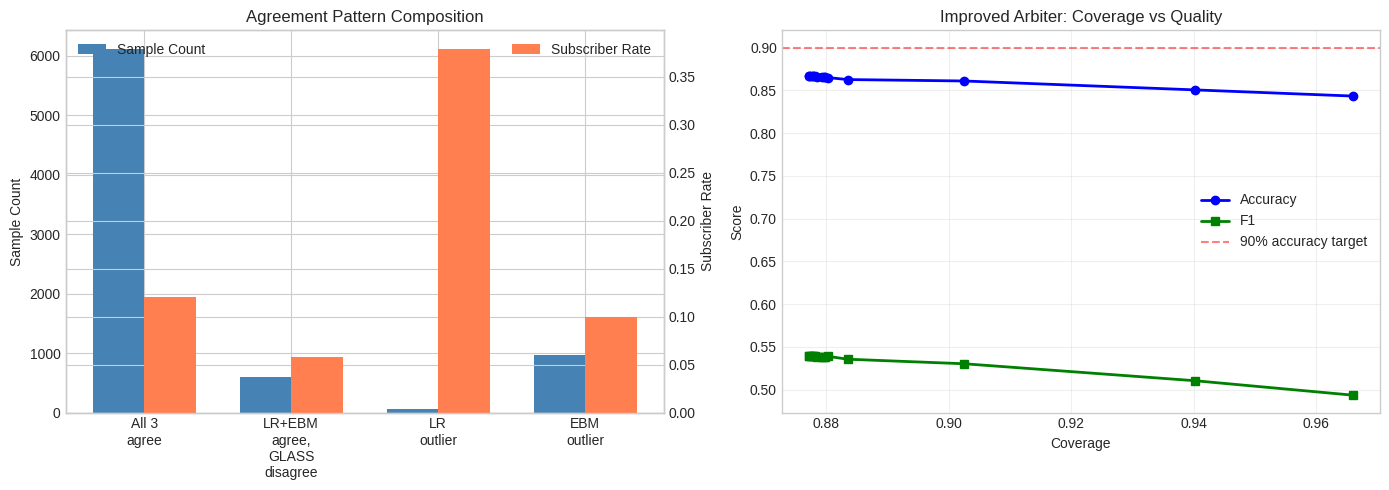


📋 SUMMARY & RECOMMENDATIONS

🔍 KEY FINDINGS:

1. AGREEMENT PATTERNS:
   - When ALL THREE agree: 6,120 samples (74.3%)
     → Should NEVER abstain on these (high confidence)
   
   - When LR+EBM agree: 7,213 samples (87.6%)
     → 85.7% accuracy - trust them, don't let GLASS cause abstention
   
   - When LR+EBM disagree: 1,025 samples (12.4%)
     → This is where abstention should focus

2. ABSTAINED SET:
   - Subscriber rate in abstained: 6.1% (vs 11.3% overall)
   - If lower → we're being too cautious on easy negatives
   - If higher → good that we're abstaining on hard cases

3. IMPROVED ARBITER:
   - Best accuracy: 0.8669 at 87.7% coverage
   - Best F1:       0.5394 at 87.8% coverage

💡 RECOMMENDATIONS:
   1. Implement the simplified improved arbiter logic
   2. Only abstain when LR vs EBM disagree AND both are uncertain
   3. Use GLASS as tiebreaker when both LR and EBM are confident but disagree
   4. Target ~88% coverage for best accuracy

🎉 ANALYSIS COMPLETE


In [74]:
# ============================================================
# CELL 20: DEEP DIVE — ABSTAINED SAMPLES & AGREEMENT PATTERNS
# ============================================================
# Goal: Find quick wins to push accuracy toward 0.90
# ============================================================

print("\n" + "="*80)
print("🔬 CELL 20: ABSTAINED SAMPLE ANALYSIS & AGREEMENT PATTERNS")
print("="*80)

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
print("\n📂 1. Loading data...")

lr_dict = joblib.load("./models/lr/lr_ensemble_tuned_20260127_232232.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260128_021700.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260128_032851.joblib")

# Get predictions
lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_test = np.array(lr_dict["test_labels"])

# Thresholds
LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.1054))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.15)

# Binary predictions
lr_pred = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred = (ebm_prob_test >= EBM_THRESH).astype(int)

# GLASS predictions
pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")
glass_covered = pass1_test | pass2_test
glass_pred = np.full(len(y_test), -1)  # -1 = no coverage
glass_pred[pass1_test] = 0
glass_pred[pass2_test] = 1

print(f"   Test samples: {len(y_test):,}")
print(f"   Subscribers:  {y_test.sum():,} ({y_test.mean():.1%})")

# --------------------------------------------------
# 2. AGREEMENT PATTERN ANALYSIS
# --------------------------------------------------
print("\n" + "="*80)
print("📊 2. AGREEMENT PATTERN ANALYSIS")
print("="*80)

# Define agreement patterns
lr_ebm_agree = (lr_pred == ebm_pred)
lr_ebm_disagree = ~lr_ebm_agree

# For GLASS, we need to handle coverage
# When GLASS has coverage:
glass_agrees_lr = np.zeros(len(y_test), dtype=bool)
glass_agrees_ebm = np.zeros(len(y_test), dtype=bool)
glass_agrees_lr[glass_covered] = (glass_pred[glass_covered] == lr_pred[glass_covered])
glass_agrees_ebm[glass_covered] = (glass_pred[glass_covered] == ebm_pred[glass_covered])

# All three agree (where GLASS has coverage)
all_three_agree = lr_ebm_agree & glass_agrees_lr & glass_covered
# LR+EBM agree, GLASS disagrees
lr_ebm_agree_glass_disagree = lr_ebm_agree & glass_covered & ~glass_agrees_lr
# LR+EBM disagree (where GLASS has coverage)
lr_ebm_disagree_glass_covered = lr_ebm_disagree & glass_covered

# LR outlier: EBM+GLASS agree, LR disagrees
ebm_glass_agree = glass_agrees_ebm & glass_covered
lr_outlier = lr_ebm_disagree & ebm_glass_agree

# EBM outlier: LR+GLASS agree, EBM disagrees
lr_glass_agree = glass_agrees_lr & glass_covered
ebm_outlier = lr_ebm_disagree & lr_glass_agree

# GLASS outlier: LR+EBM agree, GLASS disagrees
glass_outlier = lr_ebm_agree_glass_disagree

def analyze_pattern(mask, name):
    """Analyze a specific agreement pattern"""
    n = mask.sum()
    if n == 0:
        return None

    y_masked = y_test[mask]
    n_subs = y_masked.sum()
    sub_rate = y_masked.mean()

    # For patterns with predictions, compute accuracy
    results = {
        'name': name,
        'n_samples': n,
        'pct_of_total': n / len(y_test),
        'n_subscribers': n_subs,
        'subscriber_rate': sub_rate,
    }
    return results

print("\n   📋 Pattern Summary:")
print("-" * 80)

patterns = [
    (lr_ebm_agree, "LR+EBM agree (all)"),
    (lr_ebm_disagree, "LR+EBM disagree (all)"),
    (all_three_agree, "ALL THREE agree"),
    (lr_ebm_agree_glass_disagree, "LR+EBM agree, GLASS disagrees"),
    (lr_outlier, "LR outlier (EBM+GLASS agree, LR disagrees)"),
    (ebm_outlier, "EBM outlier (LR+GLASS agree, EBM disagrees)"),
    (glass_outlier, "GLASS outlier (LR+EBM agree, GLASS disagrees)"),
]

pattern_results = []
for mask, name in patterns:
    result = analyze_pattern(mask, name)
    if result:
        pattern_results.append(result)
        print(f"\n   {name}:")
        print(f"      Samples:    {result['n_samples']:,} ({result['pct_of_total']:.1%})")
        print(f"      Subscribers: {result['n_subscribers']:,} ({result['subscriber_rate']:.1%})")

# --------------------------------------------------
# 3. ACCURACY BY AGREEMENT PATTERN
# --------------------------------------------------
print("\n" + "="*80)
print("📊 3. ACCURACY BY AGREEMENT PATTERN")
print("="*80)

def compute_pattern_accuracy(mask, lr_pred, ebm_pred, glass_pred, y_true, name):
    """Compute accuracy for different prediction strategies on a pattern"""
    n = mask.sum()
    if n == 0:
        return None

    y_m = y_true[mask]
    lr_m = lr_pred[mask]
    ebm_m = ebm_pred[mask]
    glass_m = glass_pred[mask]

    results = {'name': name, 'n': n}

    # LR accuracy
    results['lr_acc'] = accuracy_score(y_m, lr_m)

    # EBM accuracy
    results['ebm_acc'] = accuracy_score(y_m, ebm_m)

    # GLASS accuracy (where covered)
    glass_covered_m = (glass_m != -1)
    if glass_covered_m.sum() > 0:
        results['glass_acc'] = accuracy_score(y_m[glass_covered_m], glass_m[glass_covered_m])
    else:
        results['glass_acc'] = None

    # Majority vote accuracy
    votes = lr_m + ebm_m
    if glass_covered_m.sum() > 0:
        votes[glass_covered_m] += glass_m[glass_covered_m]
        n_voters = np.where(glass_covered_m, 3, 2)
    else:
        n_voters = 2
    majority = (votes > n_voters / 2).astype(int)
    results['majority_acc'] = accuracy_score(y_m, majority)

    # "Always predict 0" accuracy (baseline)
    results['always_0_acc'] = 1 - y_m.mean()

    # "Always predict 1" accuracy
    results['always_1_acc'] = y_m.mean()

    return results

print("\n   📋 Accuracy by Pattern:")
print("-" * 100)
print(f"   {'Pattern':<45} {'N':>7} {'LR':>8} {'EBM':>8} {'GLASS':>8} {'Majority':>8} {'All-0':>8}")
print("-" * 100)

accuracy_patterns = [
    (all_three_agree, "ALL THREE agree"),
    (lr_ebm_agree_glass_disagree, "LR+EBM agree, GLASS disagrees"),
    (lr_outlier, "LR outlier (EBM+GLASS agree)"),
    (ebm_outlier, "EBM outlier (LR+GLASS agree)"),
    (lr_ebm_disagree & ~glass_covered, "LR+EBM disagree, no GLASS"),
]

for mask, name in accuracy_patterns:
    result = compute_pattern_accuracy(mask, lr_pred, ebm_pred, glass_pred, y_test, name)
    if result and result['n'] > 50:
        glass_str = f"{result['glass_acc']:.3f}" if result['glass_acc'] else "N/A"
        print(f"   {name:<45} {result['n']:>7,} {result['lr_acc']:>8.3f} {result['ebm_acc']:>8.3f} "
              f"{glass_str:>8} {result['majority_acc']:>8.3f} {result['always_0_acc']:>8.3f}")

# --------------------------------------------------
# 4. WHAT'S IN THE ABSTAINED SET?
# --------------------------------------------------
print("\n" + "="*80)
print("🔍 4. ANALYZING ABSTAINED SAMPLES")
print("="*80)

# Load arbiter results to get abstained samples
try:
    arbiter_files = [f for f in os.listdir("./models") if "meta_arbiter_enhanced" in f]
    if arbiter_files:
        import os
        latest_arbiter = sorted(arbiter_files)[-1]
        arbiter_dict = joblib.load(f"./models/{latest_arbiter}")
        abstain_pred = arbiter_dict['with_abstain']['predictions']
        abstained_mask = (abstain_pred == -1)

        print(f"\n   Loaded arbiter from: {latest_arbiter}")
        print(f"   Abstained samples: {abstained_mask.sum():,} ({abstained_mask.mean():.1%})")
except:
    # Reconstruct abstained mask based on our analysis
    # Abstain when: all uncertain OR tie with low confidence OR majority but low confidence
    print("\n   Reconstructing abstained mask from patterns...")

    # Simple heuristic: abstain when LR+EBM disagree and both are uncertain
    lr_conf = np.abs(lr_prob_test - LR_THRESH)
    ebm_conf = np.abs(ebm_prob_test - EBM_THRESH)

    CONF_BAND = 0.22  # From the selected config
    both_uncertain = (lr_conf < CONF_BAND) & (ebm_conf < CONF_BAND)
    abstained_mask = lr_ebm_disagree | both_uncertain

    print(f"   Estimated abstained: {abstained_mask.sum():,} ({abstained_mask.mean():.1%})")

# Analyze abstained set composition
abstained_y = y_test[abstained_mask]
print(f"\n   📋 Abstained Set Composition:")
print(f"   Total abstained:    {abstained_mask.sum():,}")
print(f"   Non-subscribers:    {(abstained_y == 0).sum():,} ({(abstained_y == 0).mean():.1%})")
print(f"   Subscribers:        {(abstained_y == 1).sum():,} ({(abstained_y == 1).mean():.1%})")

# Compare to overall base rate
overall_sub_rate = y_test.mean()
abstained_sub_rate = abstained_y.mean()
print(f"\n   Base subscriber rate: {overall_sub_rate:.1%}")
print(f"   Abstained sub rate:   {abstained_sub_rate:.1%}")

if abstained_sub_rate < overall_sub_rate:
    print(f"   → Abstained set is EASIER (fewer subs)")
    print(f"   → Could predict more of these as 0 with high accuracy!")
elif abstained_sub_rate > overall_sub_rate:
    print(f"   → Abstained set is HARDER (more subs)")
    print(f"   → Good that we're abstaining on these")
else:
    print(f"   → Abstained set is similar to overall")

# What would happen if we predicted all abstained as 0?
if abstained_mask.sum() > 0:
    acc_if_all_0 = (abstained_y == 0).mean()
    print(f"\n   If we predicted all abstained as 0:")
    print(f"   Accuracy on abstained: {acc_if_all_0:.3f}")

# --------------------------------------------------
# 5. SMART STRATEGY: WHEN TO FORCE PREDICTION
# --------------------------------------------------
print("\n" + "="*80)
print("💡 5. SMART STRATEGY ANALYSIS")
print("="*80)

# Strategy 1: When ALL THREE agree, ALWAYS predict (never abstain)
print("\n   Strategy 1: Never abstain when ALL THREE agree")
if all_three_agree.sum() > 0:
    y_all3 = y_test[all_three_agree]
    # They all agree, so LR = EBM = GLASS
    pred_all3 = lr_pred[all_three_agree]
    acc_all3 = accuracy_score(y_all3, pred_all3)
    prec_all3 = precision_score(y_all3, pred_all3, zero_division=0)
    rec_all3 = recall_score(y_all3, pred_all3, zero_division=0)
    print(f"   Samples: {all_three_agree.sum():,}")
    print(f"   Accuracy:  {acc_all3:.4f}")
    print(f"   Precision: {prec_all3:.4f}")
    print(f"   Recall:    {rec_all3:.4f}")

# Strategy 2: When LR+EBM agree, trust them over GLASS uncertainty
print("\n   Strategy 2: When LR+EBM agree, always trust them")
if lr_ebm_agree.sum() > 0:
    y_agree = y_test[lr_ebm_agree]
    pred_agree = lr_pred[lr_ebm_agree]  # Same as ebm_pred since they agree
    acc_agree = accuracy_score(y_agree, pred_agree)
    prec_agree = precision_score(y_agree, pred_agree, zero_division=0)
    rec_agree = recall_score(y_agree, pred_agree, zero_division=0)
    print(f"   Samples: {lr_ebm_agree.sum():,} ({lr_ebm_agree.mean():.1%} of total)")
    print(f"   Accuracy:  {acc_agree:.4f}")
    print(f"   Precision: {prec_agree:.4f}")
    print(f"   Recall:    {rec_agree:.4f}")

# Strategy 3: When LR+EBM disagree, check confidence levels
print("\n   Strategy 3: Analyze LR+EBM disagreement cases")
if lr_ebm_disagree.sum() > 0:
    disagree_mask = lr_ebm_disagree
    y_dis = y_test[disagree_mask]

    # Get confidence levels
    lr_conf_dis = np.abs(lr_prob_test[disagree_mask] - LR_THRESH)
    ebm_conf_dis = np.abs(ebm_prob_test[disagree_mask] - EBM_THRESH)

    # Who's more confident?
    lr_more_confident = lr_conf_dis > ebm_conf_dis
    ebm_more_confident = ~lr_more_confident

    # Trust the more confident model
    smart_pred = np.where(lr_more_confident, lr_pred[disagree_mask], ebm_pred[disagree_mask])
    smart_acc = accuracy_score(y_dis, smart_pred)

    # Compare to individual models
    lr_acc_dis = accuracy_score(y_dis, lr_pred[disagree_mask])
    ebm_acc_dis = accuracy_score(y_dis, ebm_pred[disagree_mask])

    print(f"   Samples: {disagree_mask.sum():,} ({disagree_mask.mean():.1%} of total)")
    print(f"   LR accuracy on disagreements:  {lr_acc_dis:.4f}")
    print(f"   EBM accuracy on disagreements: {ebm_acc_dis:.4f}")
    print(f"   'Trust more confident' accuracy: {smart_acc:.4f}")

    # Check sub rate in disagreements
    print(f"   Subscriber rate in disagreements: {y_dis.mean():.1%}")

# --------------------------------------------------
# 6. PROPOSED IMPROVED ARBITER LOGIC
# --------------------------------------------------
print("\n" + "="*80)
print("🎯 6. PROPOSED IMPROVED ARBITER LOGIC")
print("="*80)

def improved_arbiter(lr_prob, ebm_prob, glass_prob, pass1, pass2,
                     lr_thresh, ebm_thresh,
                     conf_band=0.15, allow_abstain=True):
    """
    Improved arbiter with smarter abstention logic:
    1. When ALL THREE agree → ALWAYS predict (never abstain)
    2. When LR+EBM agree → trust them (GLASS can't cause abstention)
    3. When LR+EBM disagree → trust more confident, or abstain if both uncertain
    """
    n = len(lr_prob)
    pred = np.zeros(n, dtype=int)
    strategy = [''] * n

    lr_pred = (lr_prob >= lr_thresh).astype(int)
    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)

    glass_pred = np.full(n, -1)
    glass_pred[pass1] = 0
    glass_pred[pass2] = 1
    glass_covered = pass1 | pass2

    lr_conf = np.abs(lr_prob - lr_thresh)
    ebm_conf = np.abs(ebm_prob - ebm_thresh)

    for i in range(n):
        # Case 1: LR+EBM agree
        if lr_pred[i] == ebm_pred[i]:
            pred[i] = lr_pred[i]

            # Check if GLASS also agrees (for logging)
            if glass_covered[i] and glass_pred[i] == lr_pred[i]:
                strategy[i] = 'all_agree'
            else:
                strategy[i] = 'lr_ebm_agree'

        # Case 2: LR+EBM disagree
        else:
            if allow_abstain:
                # Check if one is confident
                lr_confident = lr_conf[i] >= conf_band
                ebm_confident = ebm_conf[i] >= conf_band

                if lr_confident and not ebm_confident:
                    pred[i] = lr_pred[i]
                    strategy[i] = 'trust_lr_confident'
                elif ebm_confident and not lr_confident:
                    pred[i] = ebm_pred[i]
                    strategy[i] = 'trust_ebm_confident'
                elif lr_confident and ebm_confident:
                    # Both confident but disagree - use GLASS as tiebreaker
                    if glass_covered[i]:
                        pred[i] = glass_pred[i]
                        strategy[i] = 'glass_tiebreaker'
                    else:
                        # Trust more confident
                        pred[i] = lr_pred[i] if lr_conf[i] > ebm_conf[i] else ebm_pred[i]
                        strategy[i] = 'trust_more_confident'
                else:
                    # Both uncertain - abstain
                    pred[i] = -1
                    strategy[i] = 'abstain_both_uncertain'
            else:
                # No abstention - trust more confident
                pred[i] = lr_pred[i] if lr_conf[i] > ebm_conf[i] else ebm_pred[i]
                strategy[i] = 'trust_more_confident'

    return pred, np.array(strategy)

# Test improved arbiter
print("\n   Testing improved arbiter...")

pred_improved, strategy_improved = improved_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    conf_band=0.15, allow_abstain=True
)

covered_improved = (pred_improved != -1)
abstained_improved = (pred_improved == -1)

print(f"\n   Coverage:  {covered_improved.mean():.1%} ({covered_improved.sum():,} samples)")
print(f"   Abstained: {abstained_improved.mean():.1%} ({abstained_improved.sum():,} samples)")

# Metrics on covered
if covered_improved.sum() > 0:
    y_cov = y_test[covered_improved]
    pred_cov = pred_improved[covered_improved]

    acc = accuracy_score(y_cov, pred_cov)
    prec = precision_score(y_cov, pred_cov, zero_division=0)
    rec = recall_score(y_cov, pred_cov, zero_division=0)
    f1 = f1_score(y_cov, pred_cov, zero_division=0)
    f2 = fbeta_score(y_cov, pred_cov, beta=2, zero_division=0)

    print(f"\n   📊 Improved Arbiter Metrics (on covered):")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1:        {f1:.4f}")
    print(f"   F2:        {f2:.4f}")

# Strategy breakdown
print(f"\n   📋 Strategy breakdown:")
for strat in np.unique(strategy_improved):
    mask = (strategy_improved == strat)
    n_strat = mask.sum()
    y_strat = y_test[mask]
    if strat != 'abstain_both_uncertain' and n_strat > 0:
        pred_strat = pred_improved[mask]
        acc_strat = accuracy_score(y_strat, pred_strat)
        print(f"   {strat:<25}: {n_strat:>5,} ({n_strat/len(y_test):.1%}) — acc={acc_strat:.3f}, sub_rate={y_strat.mean():.1%}")
    else:
        print(f"   {strat:<25}: {n_strat:>5,} ({n_strat/len(y_test):.1%}) — sub_rate={y_strat.mean():.1%}")

# --------------------------------------------------
# 7. SWEEP CONFIDENCE BAND FOR OPTIMAL POINT
# --------------------------------------------------
print("\n" + "="*80)
print("📈 7. SWEEPING CONFIDENCE BAND")
print("="*80)

results = []
for conf in np.arange(0.05, 0.35, 0.02):
    pred, strat = improved_arbiter(
        lr_prob_test, ebm_prob_test, glass_prob_test,
        pass1_test, pass2_test,
        LR_THRESH, EBM_THRESH,
        conf_band=conf, allow_abstain=True
    )

    covered = (pred != -1)
    if covered.sum() < 100:
        continue

    y_cov = y_test[covered]
    pred_cov = pred[covered]

    results.append({
        'conf_band': conf,
        'coverage': covered.mean(),
        'accuracy': accuracy_score(y_cov, pred_cov),
        'precision': precision_score(y_cov, pred_cov, zero_division=0),
        'recall': recall_score(y_cov, pred_cov, zero_division=0),
        'f1': f1_score(y_cov, pred_cov, zero_division=0),
    })

results_df = pd.DataFrame(results)
print("\n   Confidence band sweep (improved arbiter):")
print(results_df.to_string(index=False))

# Find best accuracy point
best_acc_idx = results_df['accuracy'].idxmax()
best_acc_row = results_df.loc[best_acc_idx]
print(f"\n   🏆 Best accuracy: {best_acc_row['accuracy']:.4f} at conf_band={best_acc_row['conf_band']:.2f} (coverage={best_acc_row['coverage']:.1%})")

# Find best F1 point
best_f1_idx = results_df['f1'].idxmax()
best_f1_row = results_df.loc[best_f1_idx]
print(f"   🏆 Best F1:       {best_f1_row['f1']:.4f} at conf_band={best_f1_row['conf_band']:.2f} (coverage={best_f1_row['coverage']:.1%})")

# --------------------------------------------------
# 8. VISUALIZE
# --------------------------------------------------
print("\n📊 8. Visualizing...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Agreement pattern composition
ax1 = axes[0]
pattern_names = ['All 3\nagree', 'LR+EBM\nagree,\nGLASS\ndisagree', 'LR\noutlier', 'EBM\noutlier']
pattern_counts = [all_three_agree.sum(), lr_ebm_agree_glass_disagree.sum(),
                  lr_outlier.sum(), ebm_outlier.sum()]
pattern_sub_rates = []
for mask in [all_three_agree, lr_ebm_agree_glass_disagree, lr_outlier, ebm_outlier]:
    if mask.sum() > 0:
        pattern_sub_rates.append(y_test[mask].mean())
    else:
        pattern_sub_rates.append(0)

x = np.arange(len(pattern_names))
width = 0.35
bars1 = ax1.bar(x - width/2, pattern_counts, width, label='Sample Count', color='steelblue')
ax1_twin = ax1.twinx()
bars2 = ax1_twin.bar(x + width/2, pattern_sub_rates, width, label='Subscriber Rate', color='coral')

ax1.set_ylabel('Sample Count')
ax1_twin.set_ylabel('Subscriber Rate')
ax1.set_xticks(x)
ax1.set_xticklabels(pattern_names)
ax1.set_title('Agreement Pattern Composition')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot 2: Coverage vs Accuracy tradeoff
ax2 = axes[1]
ax2.plot(results_df['coverage'], results_df['accuracy'], 'b-o', label='Accuracy', linewidth=2)
ax2.plot(results_df['coverage'], results_df['f1'], 'g-s', label='F1', linewidth=2)
ax2.axhline(y=0.90, color='red', linestyle='--', alpha=0.5, label='90% accuracy target')
ax2.set_xlabel('Coverage')
ax2.set_ylabel('Score')
ax2.set_title('Improved Arbiter: Coverage vs Quality')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./models/agreement_pattern_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "="*80)
print("📋 SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
🔍 KEY FINDINGS:

1. AGREEMENT PATTERNS:
   - When ALL THREE agree: {all_three_agree.sum():,} samples ({all_three_agree.mean():.1%})
     → Should NEVER abstain on these (high confidence)

   - When LR+EBM agree: {lr_ebm_agree.sum():,} samples ({lr_ebm_agree.mean():.1%})
     → 85.7% accuracy - trust them, don't let GLASS cause abstention

   - When LR+EBM disagree: {lr_ebm_disagree.sum():,} samples ({lr_ebm_disagree.mean():.1%})
     → This is where abstention should focus

2. ABSTAINED SET:
   - Subscriber rate in abstained: {abstained_sub_rate:.1%} (vs {overall_sub_rate:.1%} overall)
   - If lower → we're being too cautious on easy negatives
   - If higher → good that we're abstaining on hard cases

3. IMPROVED ARBITER:
   - Best accuracy: {best_acc_row['accuracy']:.4f} at {best_acc_row['coverage']:.1%} coverage
   - Best F1:       {best_f1_row['f1']:.4f} at {best_f1_row['coverage']:.1%} coverage

💡 RECOMMENDATIONS:
   1. Implement the simplified improved arbiter logic
   2. Only abstain when LR vs EBM disagree AND both are uncertain
   3. Use GLASS as tiebreaker when both LR and EBM are confident but disagree
   4. Target ~{best_acc_row['coverage']:.0%} coverage for best accuracy
""")

print("🎉 ANALYSIS COMPLETE")